# Process GISAID metadata; updated 10/26

- Processes GISAID metadata to generate a digested set of data files, and merges with population
and case counts from Our World Of Data.
- These are the rules we're using to filter GISAID sequences:
    - at least 20000 in length
    - collection date must not be in the future and must be at the granularity of year/month/day,
      earliest Dec 2019
    - excluding sequences from the Nextstrain exclude list
    - only human samples
- Filters for future consideration (not doing these yet):
    - excluding sequences with greater than 5% ambiguous base calls (N)

In [57]:
#install packages
! pip3 install aug

In [58]:
! pip3 install argparse

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [59]:
! pip3 install datetime

In [61]:
! pip3 install numpy

In [62]:
! pip3 install pandas

In [63]:
! pip3 install requests

In [64]:
! pip3 install os_sys

  ERROR: Command errored out with exit status 1:

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
  Installing build dependencies: started
  Installing build


   command: 'C:\Users\bthrift\Anaconda3\python.exe' 'C:\Users\bthrift\Anaconda3\lib\site-packages\pip' install --ignore-installed --no-user --prefix 'C:\Users\bthrift\AppData\Local\Temp\pip-build-env-2nw7crrr\normal' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'cymem<2.1.0,>=2.0.2' 'thinc<7.2.0,>=7.1.1' wheel 'preshed<3.1.0,>=3.0.2' 'cython>=0.25' 'murmurhash<1.1.0,>=0.28.0'
       cwd: None
  Complete output (217 lines):
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\bthrift\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\bthrift\\AppData\\Local\\Temp\\pip-install-bxsm3p4b\\thinc_f81b216e822d4c7d99f456bf36f06a75\\setup.py'"'"'; __file__='"'"'C:\\Users\\bthrift\\AppData\\Local\\Temp\\pip-install-bxsm3p4b\\thinc_f81b216e822d4c7d99f456bf36f06a75\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f

    copying thinc\tests\linear\test_linear.py -> build\lib.win-amd64-3.8\thinc\tests\linear
    copying thinc\tests\linear\test_sparse_array.py -> build\lib.win-amd64-3.8\thinc\tests\linear
    copying thinc\tests\linear\__init__.py -> build\lib.win-amd64-3.8\thinc\tests\linear
    creating build\lib.win-amd64-3.8\thinc\linear
    copying thinc\linear\__init__.py -> build\lib.win-amd64-3.8\thinc\linear
    creating build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\mem.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\pooling.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\train.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\util.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\vec2vec.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\vecs2vec.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\neural\vecs2vecs.py -> build\lib.win-amd64-3.8\thinc\neural
    copying thinc\

      running build
      running build_py
      running build_ext
      building 'preshed.maps' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      ----------------------------------------
  ERROR: Command errored out with exit status 1: 'C:\Users\bthrift\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\bthrift\\AppData\\Local\\Temp\\pip-install-6on7wauz\\preshed_5f33881787364f1da10b5216a44da162\\setup.py'"'"'; __file__='"'"'C:\\Users\\bthrift\\AppData\\Local\\Temp\\pip-install-6on7wauz\\preshed_5f33881787364f1da10b5216a44da162\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\bthrift\AppData\Local\Temp\pip-record-3b5yr86b\install-record.txt' --single-version-externa

In [96]:
#import files
import datetime
from datetime import date, timedelta
import sys

from argparse import ArgumentParser, RawDescriptionHelpFormatter
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
parser = ArgumentParser(
description=__doc__,
formatter_class=RawDescriptionHelpFormatter)

parser.add_argument('--gisaid-metadata-file', default='', help='GISAID metadata file export path')
parser.add_argument('--merged-gisaid-owid-out', default='',
                    help='Path where to write merged GISAID/OWID CSV')
parser.add_argument('--make-weekly-file', action='store_true', default=False,
                    dest='make_weekly',
                    help='Create weekly file with _weekly appended to filename. Daily file is created regardless.')
parser.add_argument('--save-filtered-metadata', action='store_true', default=False,
                    dest='save_filtered_local',
                    help='Save filtered GISAID metadata file in local/bthrift.tsv')


_StoreTrueAction(option_strings=['--save-filtered-metadata'], dest='save_filtered_local', nargs=0, const=True, default=False, type=None, choices=None, help='Save filtered GISAID metadata file in local/bthrift.tsv', metavar=None)

In [42]:
##############################################################################################
####################   Designate variants for breakout columns    ############################
##############################################################################################

# greek naming from WHO (https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/)
# cross-referencing CDC (https://www.cdc.gov/coronavirus/2019-ncov/variants/variant-info.html) 
# and Outbreak.info (https://outbreak.info/situation-reports) 
# and CoVariants.org (https://covariants.org/variants)
# names are created as new cols verbatim in the weeky csv with value being the sum of sequence counts for the pango lineages in each corresponding value plus a 'who_other' column that covers the remaining sequences not designated below

greek_dict = {
    'who_alpha' :  ['B.1.1.7','Q.*'],
    'who_beta' :   ['B.1.351', 'B.1.351.2', 'B.1.351.3', 'B.1.351.4', 'B.1.351.5'],
    'who_gamma' :  ['P.1', 'P.1.*'],
    'who_delta':   ['B.1.617.2', 'AY.*'],
    'who_allvois': ['C.37', 'C.37.1', # lambda
                    'B.1.621', 'B.1.621.1', # mu
                   ]
}

# every pango lineage in the following lists are broken out as new columns verbatim plus an "All lineages" column as the sum of all sequences and "Other lineages" being "All lineages" minus these designated variant counts
vocs = greek_dict['who_alpha']\
        + greek_dict['who_beta']\
        + greek_dict['who_gamma']\
        + greek_dict['who_delta']

vois = greek_dict['who_allvois']

other_important =  ['B.1.617.3', # CDC VUM
                    'B.1.427', 'B.1.429', 'B.1.427/429', # epsilon WHO VUM
                    'B.1.525', # eta WHO VUM
                    'B.1.526', 'B.1.526.*', # iota WHO VUM
                    'B.1.617.1', # kappa WHO VUM
                    'P.2', # zeta
                    'P.3', # theta
                    ]

# if needed, combine separate lineages under one column. Note that this supersedes the lineage breakout column designations above, i.e. B.1.427 and B.1.429 are collapsed into one column named `B.1.427/429`
lineage_replace_dict = {
    'B.1.427':'B.1.427/429',
    'B.1.429':'B.1.427/429',   
}


In [43]:
#check to make sure this scrpt ran correctly
other_important

['B.1.617.3',
 'B.1.427',
 'B.1.429',
 'B.1.427/429',
 'B.1.525',
 'B.1.526',
 'B.1.526.*',
 'B.1.617.1',
 'P.2',
 'P.3']

In [44]:
##############################################################################################
######################################   GISAID data load    #################################
##############################################################################################
# filter out sequences from the Next Gen exclusion list
# TODO: do this less awkwardly

def filter_nextstrain_exclude_sequences(gisaid_df):
    url = 'https://raw.githubusercontent.com/nextstrain/ncov/master/defaults/exclude.txt'
    exclude_sequences_response = requests.get(url)
    exclude_sequences = set(
        [x for x in exclude_sequences_response.text.split('\n') if x != '' \
            and not x.startswith('#')])

    # prepend "hCoV-19/" to match the GISAID metadata column "Virus name"
    exclude_sequences = set(["hCoV-19/%s" % x for x in exclude_sequences])
    gisaid_df = gisaid_df.loc[(~gisaid_df['Virus name'].isin(exclude_sequences))]
    return gisaid_df

In [45]:
#Filter GISAID sequences
def filter_gisaid_sequences(gisaid_df):
    """
    Filter GISAID sequences. These are the rules we're using:
    - at least 20000 in length
    - collection date must not be in the future and must be at the granularity of year/month/day,
      earliest Dec 2019
    - excluding sequences from the Nextstrain exclude list
    - only human samples
    """
    today_str = date.today().strftime('%Y-%m-%d')

    # full date string, between Dec 2019 and today (no future samples allowed)
    def is_legit_date(collection_date):
        return len(collection_date) == 10 and \
            collection_date > '2019-12-01' and collection_date <= today_str
    gisaid_df = gisaid_df[gisaid_df['Collection date'].apply(is_legit_date)]

    gisaid_df = gisaid_df.loc[
        (gisaid_df['Sequence length'] > 20000) &
        (gisaid_df['Collection date'] < today_str) &
        # (gisaid_df['N-Content'] < 0.05) &
        (gisaid_df['Host'] == 'Human')
    ]

    gisaid_df = filter_nextstrain_exclude_sequences(gisaid_df)
    return gisaid_df

In [64]:
#edit dates and location names
def get_weekstartdate(dt_value):
    start = dt_value - timedelta(days=dt_value.weekday())
    return start

def titlecase_location(location_name, exceptions=['and', 'or', 'the', 'a', 'of', 'in', "d'Ivoire"]):
    word_list = [word if word in exceptions else word.capitalize() for word in location_name.split(' ')]
    return ' '.join(word_list)

def correct_location_names(gisaid_df):
    gisaid_df.loc[:,'country'] = gisaid_df['country'].apply(titlecase_location)
    gisaid_df.loc[gisaid_df['country'].fillna('').str.contains('USA', case=False), 'country'] = 'United States'
    gisaid_df.loc[gisaid_df['country'] == 'Puerto Rico', 'country'] = 'United States'
    gisaid_df.loc[gisaid_df['country'] == 'Guam', 'country'] = 'United States'
    gisaid_df.loc[gisaid_df['country'] == 'Northern Mariana Islands', 'country'] = 'United States'
    gisaid_df.loc[gisaid_df['country'] == 'U.s. Virgin Islands', 'country'] = 'United States'
    gisaid_df.loc[gisaid_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
    gisaid_df.loc[gisaid_df['country'] == 'Antigua', 'country'] = 'Antigua and Barbuda'
    gisaid_df.loc[gisaid_df['country'] == 'Democratic Republic of the Congo', 'country'] = 'Democratic Republic of Congo'
    gisaid_df.loc[gisaid_df['country'] == 'Republic of the Congo', 'country'] = 'Congo'
    gisaid_df.loc[gisaid_df['country'] == 'Faroe Islands', 'country'] = 'Faeroe Islands'
    gisaid_df.loc[gisaid_df['country'] == 'Guinea Bissau', 'country'] = 'Guinea-Bissau'
    gisaid_df.loc[gisaid_df['country'] == 'Niogeria', 'country'] = 'Nigeria'
    gisaid_df.loc[gisaid_df['country'] == 'Bosni and Herzegovina', 'country'] = 'Bosnia and Herzegovina'
    gisaid_df.loc[gisaid_df['country'] == 'England', 'country'] = 'United Kingdom'
    gisaid_df.loc[gisaid_df['country'] == 'The Bahamas', 'country'] = 'Bahamas'
    return gisaid_df

def annotate_sequences(gisaid_df):
    gisaid_df['region'] = gisaid_df.Location.apply(lambda x: x.split('/')[0].strip())
    gisaid_df['country'] = gisaid_df.Location.apply(lambda x: x.split('/')[1].strip())
    gisaid_df['division'] = gisaid_df.Location.apply(
        lambda x: x.split('/')[2].strip() if len(x.split('/'))>2 else '')

    # replace 'USA' string with 'United States' etc in location, to match OWID location name
    gisaid_df = correct_location_names(gisaid_df)

    gisaid_df['collect_date'] = pd.to_datetime(gisaid_df['Collection date'])
    gisaid_df['submit_date'] = pd.to_datetime(gisaid_df['Submission date'])

    gisaid_df['lag_days'] = gisaid_df['submit_date'] - gisaid_df['collect_date']
    gisaid_df['lag_days'] = gisaid_df['lag_days'].dt.days.astype('int')

    # using ISO 8601 year and week (Monday as the first day of the week. Week 01 is the week containing Jan 4)
    gisaid_df['collect_yearweek'] = gisaid_df['collect_date'].apply(lambda x: datetime.datetime.strftime(x, "%G-W%V"))
    gisaid_df['submit_yearweek'] = gisaid_df['submit_date'].apply(lambda x: datetime.datetime.strftime(x, "%G-W%V"))

    gisaid_df['collect_weekstartdate'] = gisaid_df['collect_date'].apply(get_weekstartdate)
    gisaid_df['submit_weekstartdate'] = gisaid_df['submit_date'].apply(get_weekstartdate)

    return gisaid_df

def subset_gisaid_df(gisaid_df):
    cols = ['Collection date','Accession ID','Pango lineage',
            'Location','region','country','division',
            'collect_date', 'submit_date', 'lag_days',
            'collect_yearweek','collect_weekstartdate',
            'submit_yearweek','submit_weekstartdate']
    return gisaid_df[cols]

def load_and_filter_gisaid_df(local_path_file):
    gisaid_df = pd.read_csv('C:\\Users\\bthrift\\Documents\\Projects\\NGS Map\\R_script_required_data\\GISAID_metadata_10_18_2021.tsv', sep='\t')
    print(f'Top 20 lineages:\n{gisaid_df["Pango lineage"].value_counts()[:20]}')
    print(f'Pangolin versions present:\n{gisaid_df["Pangolin version"].value_counts(dropna=False)}')
    gisaid_df = filter_gisaid_sequences(gisaid_df)
    gisaid_df = annotate_sequences(gisaid_df)
    gisaid_df = subset_gisaid_df(gisaid_df)
    return gisaid_df



In [65]:
#Get Pango Lineages that exist in latest GISAID dataset
def find_lineages(input_pango, search_pango):
    # retrieve the pango lineages that exist in the latest gisaid set including sublineages wildcarded with *, i.e. "AY.*"
    match_list = sorted(set(search_pango) & set(input_pango))
    print('  Matched these lineages:', match_list)
    wildcards = [c for c in input_pango if '*' in c]
    wildcard_res = []
    for w in wildcards:
        res = [c for c in set(search_pango) if w.replace('*','') == str(c)[:len(w)-1]]
        print(f'  Found {w}:',sorted(res))
        wildcard_res += res
    not_found = set(input_pango)-set(wildcards)-set(match_list)
    if len(not_found)>0: print('  Not found:', not_found)
    return sorted(match_list+wildcard_res)

def aggregate_with_lineage(gisaid_df):
    country_variants_df = gisaid_df.groupby(
        ['Collection date','collect_yearweek','collect_weekstartdate','country','Pango lineage']).count()[['Accession ID']].reset_index()
    # find pango lineages that are actually present in gisaid metadata, including wildcards
    key_variants = find_lineages(vocs + vois + other_important, gisaid_df['Pango lineage'].unique())
    # label these lineages of interest for breaking out into cols
    country_variants_df['key_lineages'] = country_variants_df['Pango lineage'].apply(
        lambda x: x if x in key_variants else 'Other lineages')
    # manually combine lineages, i.e. B.1.427 and B.1.429 under B.1.427/429
    country_variants_df['key_lineages'].replace(lineage_replace_dict, inplace=True)
    
    all_sequences = gisaid_df.groupby(
        ['collect_date','collect_yearweek','collect_weekstartdate','country']).count()[['Accession ID']].reset_index()
    all_sequences['key_lineages'] = 'All lineages'
    country_variants_df = pd.concat([country_variants_df, all_sequences], sort=True)
 
    # rename columns a bit
    country_variants_df.columns = ['_'.join(c.lower().split()) for c in country_variants_df.columns]
    return country_variants_df

def calc_lagstats(gisaid_df, group_cols=['collect_date','country']):
    # precalculate summary stats about lag time from date_collect to date_submit for all filtered sequences per day and country
    def q1(x): return x.quantile(0.25)
    def q3(x): return x.quantile(0.75)
    sumstats_df = gisaid_df.groupby(group_cols).agg({'lag_days':['count','median','min','max',q1,q3]}).reset_index()
    sumstats_df.rename(columns={'count':'seq_count',
                       'median':'gisaid_lagdays_median',
                       'q1':'gisaid_lagdays_q1',
                       'q3':'gisaid_lagdays_q3',
                       'min':'gisaid_lagdays_min',
                       'max':'gisaid_lagdays_max',
                       'lag_days':'',
                       }, inplace=True)
    sumstats_df.columns = sumstats_df.columns.map(''.join)
    return sumstats_df


In [66]:
##############################################################################################
######################################   OWID data load    ###################################
##############################################################################################

def load_owid_df():
    url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
    owid_df = pd.read_csv(url, parse_dates=['date'])
    owid_df.sort_values(['location','date'], ascending=True, inplace=True)
    # only keep data after Dec 2019
    owid_df = owid_df[owid_df['date']>='2019-12-01']

    # drop owid region rows which start with OWID_ except specific locations
    owid_df = owid_df[~owid_df['iso_code'].isin([
                                                'OWID_AFR', # Africa
                                                'OWID_ASI', # Asia
                                                'OWID_EUR', # Europe
                                                'OWID_EUN', # European Union
                                                'OWID_INT', # International
                                                # 'OWID_KOS', # Kosovo
                                                'OWID_NAM', # North America
                                                # 'OWID_CYN', # North Cyprus
                                                'OWID_OCE', # Oceania
                                                'OWID_SAM', # South America
                                                'OWID_WRL', # World
                                                ])]

    # subset of columns, prepend 'owid_' to each column name
    owid_cols = ['date','location','iso_code','continent','new_cases','new_cases_smoothed','population','people_vaccinated','people_fully_vaccinated']
    owid_df = owid_df[owid_cols]
    
    # add vax columns calculating the daily change in people vaccinated to roll up into weekly sums
    for loc in owid_df.location.unique():
        owid_df.loc[owid_df['location']==loc,'new_people_vaccinated'] = owid_df[owid_df['location']==loc]['people_vaccinated'].ffill().fillna(0).diff()
        owid_df.loc[owid_df['location']==loc,'new_people_fully_vaccinated'] = owid_df[owid_df['location']==loc]['people_fully_vaccinated'].ffill().fillna(0).diff()        

    owid_df.columns = ['owid_%s' % x for x in owid_df.columns]
    
    return owid_df


In [67]:
owid_df.head()

,owid_date,owid_location,owid_iso_code,owid_continent,owid_new_cases,owid_new_cases_smoothed,owid_population,owid_people_vaccinated,owid_people_fully_vaccinated,owid_new_people_vaccinated,owid_new_people_fully_vaccinated
0,2020-02-24,Afghanistan,AFG,Asia,5.0,NaN,39835428.0,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0


In [68]:
##############################################################################################
##################################      Merge and pivot data   ###############################
##############################################################################################

def merge_gisaid_owid(country_variants_df, owid_df):    
    merged_df = pd.merge(country_variants_df, owid_df,
        how='outer',
        left_on=['collect_date', 'country'],
        right_on=['owid_date', 'owid_location'],
    )

    # copy missing values from OWID data to GISAID columns and vice versa as necessary (GISAID will lag)
    merged_df['collect_date']= np.where(
        merged_df['collect_date'].isnull(), merged_df['owid_date'], merged_df['collect_date'])
    merged_df['owid_date']= np.where(
        merged_df['owid_date'].isnull(), merged_df['collect_date'], merged_df['owid_date'])
    merged_df['country']= np.where(
        merged_df['country'].isnull(), merged_df['owid_location'], merged_df['country'])
    
    return merged_df

def pivot_merged_df(merged_df):
  # # add a placeholder in order to pivot on key_lineages and not drop empty collect_date rows
    merged_df['key_lineages'] = merged_df['key_lineages'].fillna('placeholder_dropmeplease')
    
    country_variants_pivot = merged_df.pivot_table(
        values=['accession_id'], aggfunc='sum', dropna=False, index=['collect_date','country'],
        columns=['key_lineages']).droplevel(axis=1, level=0).reset_index()

    # reorganize col order
    country_variants_pivot = country_variants_pivot[['collect_date','country','placeholder_dropmeplease','All lineages']+sorted([c for c in country_variants_pivot.columns if '.' in c])+['Other lineages']]

    # merge in owid cases columns which are date-dependent
    cols = ['owid_location', 'owid_date', 'owid_new_cases', 'owid_new_cases_smoothed','owid_new_people_vaccinated','owid_new_people_fully_vaccinated']
    country_variants_all_lineages = merged_df[
        merged_df['key_lineages'].isin(['All lineages','placeholder_dropmeplease'])][cols]
    country_variants_pivot = pd.merge(
        country_variants_pivot, country_variants_all_lineages, 
        how='left',
        left_on=['country','collect_date'],
        right_on=['owid_location','owid_date'],
    )

    # merge in owid population regardless of date
    country_variants_pivot = pd.merge(
        country_variants_pivot, 
        merged_df[merged_df['key_lineages'].isin(['All lineages','placeholder_dropmeplease'])][['owid_location', 'owid_continent', 'owid_population']].drop_duplicates(),
        how='left',
        left_on=['country'],
        right_on=['owid_location'],
        suffixes=('_drop',''),
    )
    # drop the original owid_location col which is sparser across the timeseries
    country_variants_pivot.drop('owid_location_drop', axis=1, inplace=True)

    # copy over collect_date where owid_date is missing, otherwise owid_date is NaT which gets filtered out
    country_variants_pivot['owid_date']= np.where(
        country_variants_pivot['owid_date'].isnull(), country_variants_pivot['collect_date'], country_variants_pivot['owid_date'])
    country_variants_pivot.sort_values(
        ['owid_date','owid_location'], ascending=[True, True], inplace=True)

    # fill out the yearweek and weekstartdate missing value
    country_variants_pivot['collect_yearweek'] = country_variants_pivot['collect_date'].apply(lambda x: datetime.datetime.strftime(x, "%G-W%V"))
    country_variants_pivot['collect_weekstartdate'] = country_variants_pivot['collect_date'].apply(get_weekstartdate)

    country_variants_pivot.drop('placeholder_dropmeplease', axis=1, inplace=True)

    return country_variants_pivot

#adding in LOCAL pathname for saved .csv file
def add_regions(merged_df, region_path='https://raw.githubusercontent.com/covid-tracking-collab/gisaid-variants/main/data/who-regions.csv'):
    who_regions = pd.read_csv(region_path)
    merged_df = pd.merge(merged_df, who_regions[['Entity','WHO region']], how='left', left_on=['owid_location'], right_on=['Entity'])
    merged_df.rename(columns={'WHO region': 'who_region'}, inplace=True)
    merged_df.drop('Entity', axis=1, inplace=True)
    return merged_df

In [69]:
merged_df.head()

,accession_id,collection_date,pango_lineage,collect_date,collect_weekstartdate,collect_yearweek,country,key_lineages,owid_date,owid_location,owid_iso_code,owid_continent,owid_new_cases,owid_new_cases_smoothed,owid_population,owid_people_vaccinated,owid_people_fully_vaccinated,owid_new_people_vaccinated,owid_new_people_fully_vaccinated
0,1.0,2019-12-24,B,NaT,2019-12-23,2019-W52,China,Other lineages,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2019-12-26,B,NaT,2019-12-23,2019-W52,China,Other lineages,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2019-12-30,A,NaT,2019-12-30,2020-W01,China,Other lineages,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17.0,2019-12-30,B,NaT,2019-12-30,2020-W01,China,Other lineages,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2019-12-31,B,NaT,2019-12-30,2020-W01,China,Other lineages,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:

# OWID dataset already has a continent column so using that instead
# def add_continents(merged_df, region_path='data/continents-according-to-our-world-in-data.csv'):
#     continents = pd.read_csv(region_path)
#     merged_df = pd.merge(merged_df, continents[['Entity','Continent']], how='left', left_on=['owid_location'], right_on=['Entity'])
#     merged_df.rename(columns={'Continent': 'owid_continent'}, inplace=True)
#     merged_df.drop('Entity', axis=1, inplace=True)
#     return merged_df    

def concat_agglocations(merged_pivoted_df, group_cols=['collect_date','collect_yearweek','collect_weekstartdate','owid_date']):
    continents_df = merged_pivoted_df.groupby(group_cols+['owid_continent']).sum().reset_index()
    whoregions_df = merged_pivoted_df.groupby(group_cols+['who_region']).sum().reset_index()
    global_df = merged_pivoted_df.groupby(group_cols).sum().reset_index()
    
    # create new col to distinguish these from country-level rows
    continents_df.loc[:,'aggregate_location'] = continents_df['owid_continent']
    whoregions_df.loc[:,'aggregate_location'] = 'WHO Region: ' + whoregions_df['who_region']
    global_df.loc[:,'aggregate_location'] = 'Global'
    
    agglocation_df = pd.concat([continents_df, whoregions_df, global_df], sort=False)

    return agglocation_df

def calc_regional_lagstats(gisaid_owid_df, group_cols=['collect_weekstartdate']):
    continents_sumstats_df = calc_lagstats(gisaid_owid_df, group_cols=group_cols+['owid_continent'])
    whoregions_sumstats_df = calc_lagstats(gisaid_owid_df, group_cols=group_cols+['who_region'])
    global_sumstats_df = calc_lagstats(gisaid_owid_df, group_cols=group_cols)

    continents_sumstats_df.loc[:,'aggregate_location'] = continents_sumstats_df['owid_continent']
    whoregions_sumstats_df.loc[:,'aggregate_location'] = 'WHO Region: '+ whoregions_sumstats_df['who_region']
    global_sumstats_df.loc[:,'aggregate_location'] = 'Global'

    return pd.concat([whoregions_sumstats_df, continents_sumstats_df, global_sumstats_df], sort=False)

def cleanup_columns(merged_df, gisaid_cols):
    # prepend gisaid_ to respective columns except for the lineage ones
    renamed_cols = {c:'gisaid_'+c for c in merged_df.columns if (c in gisaid_cols)}
    merged_df.rename(columns=renamed_cols, inplace=True)
    return merged_df

def calc_vax_bottomup(vax_df, loc_col = 'owid_location'):
    # adding up the daily or weekly new people vaccinated per region and then calculating the percent of pop
    for loc in vax_df[loc_col].unique():
      vax_df.loc[vax_df[loc_col]==loc,'owid_people_vaccinated'] = vax_df[vax_df[loc_col]==loc]['owid_new_people_vaccinated'].cumsum()
      vax_df.loc[vax_df[loc_col]==loc,'owid_people_fully_vaccinated'] = vax_df[vax_df[loc_col]==loc]['owid_new_people_fully_vaccinated'].cumsum()
    
    vax_df['owid_people_vaccinated_per_hundred'] = np.round(vax_df['owid_people_vaccinated'] / (vax_df['owid_population']/100),2)
    vax_df['owid_people_fully_vaccinated_per_hundred'] = np.round(vax_df['owid_people_fully_vaccinated'] / (vax_df['owid_population']/100),2)
    return vax_df

def get_owid_vax_regional(get_weekly=True):
    iso2loc_dict = {
        'OWID_AFR':'Africa',
        'OWID_ASI':'Asia',
        'OWID_EUR':'Europe',
        'OWID_NAM':'North America',
        'OWID_OCE':'Oceania',
        'OWID_SAM':'South America',
        'OWID_WRL':'Global',
    }
    owid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
    owid_vax_df = pd.read_csv(owid_url, parse_dates=['date'])[['iso_code','date','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred']]
    owid_vax_df.columns = ['owid_%s' % x for x in owid_vax_df.columns]
    owid_vax_df['aggregate_location'] = owid_vax_df['owid_iso_code'].map(iso2loc_dict)
    owid_vax_df['gisaid_collect_weekstartdate'] = owid_vax_df['owid_date'].apply(get_weekstartdate)
    owid_vax_df.drop('owid_iso_code', axis=1, inplace=True)

    region_vax_df = owid_vax_df[(~owid_vax_df['aggregate_location'].isna())]
    
    # only use data from the last day of each week to represent the week's progress
    if get_weekly: region_vax_df = region_vax_df[(region_vax_df['owid_date'].dt.weekday==6)]
    
    return region_vax_df

In [71]:
#Overwrite vax regions from OWID
def overwrite_vax_regional(df):
    # overwrite these calculated fields at the continent and global level with OWID reported values because of discrepancy vs the bottom-up calcs
    overwrite_cols = ['owid_people_vaccinated_per_hundred','owid_people_fully_vaccinated_per_hundred']
    regional_vax_weekly_df = get_owid_vax_regional()
    overwrite_locations = regional_vax_weekly_df['aggregate_location'].unique()
    
    df.loc[df['aggregate_location'].isin(overwrite_locations), overwrite_cols] = np.nan
    df.set_index(['aggregate_location','gisaid_collect_weekstartdate'], inplace=True)
    regional_vax_weekly_df.set_index(['aggregate_location','gisaid_collect_weekstartdate'], inplace=True)
    for col in overwrite_cols: 
        df[col].update(regional_vax_weekly_df[col])
    df.reset_index(inplace=True)
    return df

In [72]:
#calculations
def calculate_cols(df):
    df['sequences_over_new_cases'] = df['All lineages'] / df['owid_new_cases']
    df.replace(np.inf, np.nan, inplace=True)
    df['new_cases_per_mil'] = df['owid_new_cases'] / (df['owid_population']/1e6)
    return df

In [73]:
#aggregate weekly
def aggregate_weekly(df):
    df = df[[c for c in df.columns if 'lagdays' not in c]] # drop the lagday summary stat cols, need to recompute these
    weekly_agg_df = df.groupby(['gisaid_collect_weekstartdate','gisaid_collect_yearweek','gisaid_country']).sum().reset_index()
    weekly_agg_df.drop(['owid_population','owid_new_cases_smoothed'], axis=1, inplace=True)
    weekly_agg_df = pd.merge(weekly_agg_df, df[['owid_location','owid_population','who_region','owid_continent']].drop_duplicates(), 
                            how='left', left_on=['gisaid_country'], right_on=['owid_location'])
    return weekly_agg_df

In [74]:
#add greek columns
def add_greek_cols(df):
    # break out new columns aggregating the counts of variants grouped under WHO greek letters designated in greek_dict at top
    # first find the lineages that exist in this gisaid export
    greek_lineages_flattened = [v for v in greek_dict.values() for v in v]
    match_list = find_lineages(greek_lineages_flattened, set(df.columns))
    
    # group lineages under each greek letter designation, sum, and create new 'who_' col for them
    print('Grouping into greek cols:','\n--------------------------')
    who_list = []
    for k, v in greek_dict.items(): 
        print(f'Finding and grouping lineages for {k}:')
        v_existing = find_lineages(v, set(df.columns))
        df[k] = df[v_existing].sum(axis=1)
        print('-->',k,':',v_existing)
        who_list += v_existing
    df['who_other'] = df['All lineages'] - df[match_list].sum(axis=1)
    return df

In [75]:
def main(args_list=None):
    if args_list is None:
        args_list = sys.argv[1:]
    args = parser.parse_args(args_list)

In [76]:
print('Loading and filtering GISAID data...')
#Import raw GISAID data from website
gisaid_df = load_and_filter_gisaid_df("C:\\Users\\bthrift\\Documents\\Projects\\NGS Map\\R_script_required_data\\GISAID_metadata_10_18_2021.tsv")
gisaid_cols = list(gisaid_df.columns)
print('Done, %d sequences' % gisaid_df.shape[0])

print('Aggregating GISAID data...')
print('Break out key pango lineages into columns')
gisaid_country_variants_df = aggregate_with_lineage(gisaid_df)
print('Done.')

print('Loading OWID data...')
owid_df = load_owid_df()
print('Done, %d rows' % owid_df.shape[0])



Loading and filtering GISAID data...


C:\Users\bthrift\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Top 20 lineages:
B.1.1.7      1095602
AY.4          733215
B.1.617.2     608577
B.1.2         109265
AY.25         109054
B.1           104246
None          101697
B.1.177        75342
P.1            74501
AY.3           65541
B.1.1          55902
AY.5           43267
B.1.526        41622
B.1.429        41412
AY.29          40344
AY.9           40214
AY.26          35488
B.1.351        32267
B.1.160        30054
AY.33          26020
Name: Pango lineage, dtype: int64
Pangolin versions present:
2021-09-28    4387162
2021-09-16      15620
2021-08-09         24
2021-04-14          3
2021-06-15          1
Name: Pangolin version, dtype: int64
Done, 4211350 sequences
Aggregating GISAID data...
Break out key pango lineages into columns
  Matched these lineages: ['B.1.1.7', 'B.1.351', 'B.1.351.2', 'B.1.351.3', 'B.1.351.5', 'B.1.427', 'B.1.429', 'B.1.525', 'B.1.526', 'B.1.617.1', 'B.1.617.2', 'B.1.617.3', 'B.1.621', 'B.1.621.1', 'C.37', 'C.37.1', 'P.1', 'P.2', 'P.3']
  Found Q.*: ['Q.1', 'Q.2', 

In [77]:
#edit some variable names in the imported raw gisaid df
gisaid_df.head()
gisaid_df.rename(columns={ 'Collection date': 'collection_date'}, inplace = True)
gisaid_df.head()

,collection_date,Accession ID,Pango lineage,Location,region,country,division,collect_date,submit_date,lag_days,collect_yearweek,collect_weekstartdate,submit_yearweek,submit_weekstartdate
0,2020-03-25,EPI_ISL_426900,B.1,Oceania / Australia / Northern Territory,Oceania,Australia,Northern Territory,2020-03-25,2020-04-17,23,2020-W13,2020-03-23,2020-W16,2020-04-13
1,2020-03-25,EPI_ISL_426901,B.1,Oceania / Australia / Northern Territory,Oceania,Australia,Northern Territory,2020-03-25,2020-04-17,23,2020-W13,2020-03-23,2020-W16,2020-04-13
2,2020-03-26,EPI_ISL_426902,B.40,Oceania / Australia / Northern Territory,Oceania,Australia,Northern Territory,2020-03-26,2020-04-17,22,2020-W13,2020-03-23,2020-W16,2020-04-13
3,2020-03-24,EPI_ISL_426903,B.1.8,Oceania / Australia / Northern Territory,Oceania,Australia,Northern Territory,2020-03-24,2020-04-17,24,2020-W13,2020-03-23,2020-W16,2020-04-13
4,2020-03-24,EPI_ISL_426904,B.1.8,Oceania / Australia / Northern Territory,Oceania,Australia,Northern Territory,2020-03-24,2020-04-17,24,2020-W13,2020-03-23,2020-W16,2020-04-13


In [78]:
owid_df.head()

,owid_date,owid_location,owid_iso_code,owid_continent,owid_new_cases,owid_new_cases_smoothed,owid_population,owid_people_vaccinated,owid_people_fully_vaccinated,owid_new_people_vaccinated,owid_new_people_fully_vaccinated
0,2020-02-24,Afghanistan,AFG,Asia,5.0,NaN,39835428.0,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,AFG,Asia,0.0,NaN,39835428.0,NaN,NaN,0.0,0.0


In [79]:
print('Merging GISAID and OWID data...')
merged_df = merge_gisaid_owid(gisaid_country_variants_df, owid_df)
print('Pivoting merged data...')
merged_pivoted_df = pivot_merged_df(merged_df)
print('Add region assignments to countries...')
merged_pivoted_df = add_regions(merged_pivoted_df)
# merged_pivoted_df = add_continents(merged_pivoted_df)
print('Aggregate locations and concatenate...')
agglocation_df = concat_agglocations(merged_pivoted_df)
merged_pivoted_df = pd.concat([merged_pivoted_df, agglocation_df], sort=False)
print('Add submission lag stats...')
sumstats_df = calc_lagstats(gisaid_df)  
merged_pivoted_df = pd.merge(merged_pivoted_df, sumstats_df, how='left')
print('Final data file cleanup...')
merged_pivoted_df = cleanup_columns(merged_pivoted_df, gisaid_cols)
print(f'Locations without OWID join and how many sequences:\n{merged_pivoted_df[(merged_pivoted_df["owid_location"].isna())&(merged_pivoted_df["aggregate_location"].isna())].groupby("gisaid_country").sum()["All lineages"]}')
print('Done.')

Merging GISAID and OWID data...
Pivoting merged data...
Add region assignments to countries...
Aggregate locations and concatenate...
Add submission lag stats...
Final data file cleanup...
Locations without OWID join and how many sequences:
gisaid_country
Bonaire                       503.0
Cabo Verde                     40.0
Canary Islands                430.0
Crimea                         36.0
French Guiana                 828.0
Guadeloupe                    508.0
Guinea-bissau                  48.0
Martinique                    521.0
Mayotte                       727.0
Reunion                      3453.0
Saint Barthelemy                9.0
Saint Martin                   10.0
Sint Eustatius                  4.0
Sint Maarten                 1637.0
Slovak Republic                 1.0
Timor-leste                   354.0
Wallis and Futuna Islands      10.0
Name: All lineages, dtype: float64
Done.


In [80]:
max_gisaid_date = gisaid_df.submit_date.max()
merged_pivoted_df_latest = merged_pivoted_df.loc[(merged_pivoted_df.owid_date <= max_gisaid_date)]

In [81]:
merged_pivoted_df_latest.head()

,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_yearweek,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3
0,2019-12-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-24,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-24,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-24,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-24,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#export file to csv
merged_pivoted_df_latest.to_csv('C:\\Users\\bthrift\\Documents\\Projects\\FIND Map\\output_data\\GISAID_update_10_29.csv', index=False)

# Export the data structure

In [120]:
print (merged_pivoted_df_latest.columns.nunique())
print (list(merged_pivoted_df_latest.columns))

106
['gisaid_collect_date', 'gisaid_country', 'All lineages', 'AY.1', 'AY.10', 'AY.11', 'AY.12', 'AY.13', 'AY.14', 'AY.15', 'AY.16', 'AY.17', 'AY.18', 'AY.19', 'AY.2', 'AY.20', 'AY.21', 'AY.22', 'AY.23', 'AY.24', 'AY.25', 'AY.26', 'AY.27', 'AY.28', 'AY.29', 'AY.3', 'AY.3.1', 'AY.30', 'AY.31', 'AY.32', 'AY.33', 'AY.34', 'AY.35', 'AY.36', 'AY.37', 'AY.38', 'AY.4', 'AY.4.1', 'AY.5', 'AY.5.1', 'AY.5.2', 'AY.6', 'AY.7', 'AY.7.1', 'AY.7.2', 'AY.8', 'AY.9', 'B.1.1.7', 'B.1.351', 'B.1.351.2', 'B.1.351.3', 'B.1.351.5', 'B.1.427/429', 'B.1.525', 'B.1.526', 'B.1.617.1', 'B.1.617.2', 'B.1.617.3', 'B.1.621', 'B.1.621.1', 'C.37', 'C.37.1', 'P.1', 'P.1.1', 'P.1.10', 'P.1.10.1', 'P.1.10.2', 'P.1.11', 'P.1.12', 'P.1.2', 'P.1.3', 'P.1.4', 'P.1.5', 'P.1.6', 'P.1.7', 'P.1.8', 'P.1.9', 'P.2', 'P.3', 'Q.1', 'Q.2', 'Q.3', 'Q.4', 'Q.5', 'Q.6', 'Q.7', 'Q.8', 'Other lineages', 'owid_date', 'owid_new_cases', 'owid_new_cases_smoothed', 'owid_new_people_vaccinated', 'owid_new_people_fully_vaccinated', 'owid_locati

In [122]:
#export list of variables to csv
list(merged_pivoted_df_latest.columns)

['gisaid_collect_date',
 'gisaid_country',
 'All lineages',
 'AY.1',
 'AY.10',
 'AY.11',
 'AY.12',
 'AY.13',
 'AY.14',
 'AY.15',
 'AY.16',
 'AY.17',
 'AY.18',
 'AY.19',
 'AY.2',
 'AY.20',
 'AY.21',
 'AY.22',
 'AY.23',
 'AY.24',
 'AY.25',
 'AY.26',
 'AY.27',
 'AY.28',
 'AY.29',
 'AY.3',
 'AY.3.1',
 'AY.30',
 'AY.31',
 'AY.32',
 'AY.33',
 'AY.34',
 'AY.35',
 'AY.36',
 'AY.37',
 'AY.38',
 'AY.4',
 'AY.4.1',
 'AY.5',
 'AY.5.1',
 'AY.5.2',
 'AY.6',
 'AY.7',
 'AY.7.1',
 'AY.7.2',
 'AY.8',
 'AY.9',
 'B.1.1.7',
 'B.1.351',
 'B.1.351.2',
 'B.1.351.3',
 'B.1.351.5',
 'B.1.427/429',
 'B.1.525',
 'B.1.526',
 'B.1.617.1',
 'B.1.617.2',
 'B.1.617.3',
 'B.1.621',
 'B.1.621.1',
 'C.37',
 'C.37.1',
 'P.1',
 'P.1.1',
 'P.1.10',
 'P.1.10.1',
 'P.1.10.2',
 'P.1.11',
 'P.1.12',
 'P.1.2',
 'P.1.3',
 'P.1.4',
 'P.1.5',
 'P.1.6',
 'P.1.7',
 'P.1.8',
 'P.1.9',
 'P.2',
 'P.3',
 'Q.1',
 'Q.2',
 'Q.3',
 'Q.4',
 'Q.5',
 'Q.6',
 'Q.7',
 'Q.8',
 'Other lineages',
 'owid_date',
 'owid_new_cases',
 'owid_new_cases_smo

In [82]:
print (merged_pivoted_df_latest.gisaid_collect_date.unique())
#Dates: December 2019 through Oct 17th 2021

['2019-12-24T00:00:00.000000000' '2019-12-26T00:00:00.000000000'
 '2019-12-30T00:00:00.000000000' '2019-12-31T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000' '2020-01-02T00:00:00.000000000'
 '2020-01-03T00:00:00.000000000' '2020-01-04T00:00:00.000000000'
 '2020-01-05T00:00:00.000000000' '2020-01-06T00:00:00.000000000'
 '2020-01-07T00:00:00.000000000' '2020-01-08T00:00:00.000000000'
 '2020-01-09T00:00:00.000000000' '2020-01-10T00:00:00.000000000'
 '2020-01-11T00:00:00.000000000' '2020-01-12T00:00:00.000000000'
 '2020-01-13T00:00:00.000000000' '2020-01-14T00:00:00.000000000'
 '2020-01-15T00:00:00.000000000' '2020-01-16T00:00:00.000000000'
 '2020-01-17T00:00:00.000000000' '2020-01-18T00:00:00.000000000'
 '2020-01-19T00:00:00.000000000' '2020-01-20T00:00:00.000000000'
 '2020-01-21T00:00:00.000000000' '2020-01-22T00:00:00.000000000'
 '2020-01-23T00:00:00.000000000' '2020-01-24T00:00:00.000000000'
 '2020-01-25T00:00:00.000000000' '2020-01-26T00:00:00.000000000'
 '2020-01-27T00:00:00.000

In [101]:
print ("num of na in gisaid metadata oct dataset:", 
       merged_pivoted_df_latest.seq_count.isna().sum())

num of na in gisaid metadata oct dataset: 129586


In [186]:
merged_pivoted_df_latest.sort_values(by=['gisaid_country', 'gisaid_collect_date'], ascending=True, inplace=True)
merged_pivoted_df_latest.head(4)

<ipython-input-186-a3eb577696de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pivoted_df_latest.sort_values(by=['gisaid_country', 'gisaid_collect_date'], ascending=True, inplace=True)


,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3,seq_difference
0,2019-12-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2019-12-26,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
490,2019-12-30,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-30,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
735,2019-12-31,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-30,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [193]:
merged_pivoted_df_latest ['seq_difference'] = merged_pivoted_df_latest.seq_count.diff()
merged_pivoted_df_latest.tail()

<ipython-input-193-538d0e4c136c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pivoted_df_latest ['seq_difference'] = merged_pivoted_df_latest.seq_count.diff()


,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3,seq_difference
176644,2021-10-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-11,Eastern Mediterranean,WHO Region: Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176645,2021-10-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-11,Europe,WHO Region: Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176646,2021-10-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-11,South-East Asia,WHO Region: South-East Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176647,2021-10-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-11,Western Pacific,WHO Region: Western Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177475,2021-10-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2021-10-11,NaN,Global,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
#where difference is not zero
where_seq_is_not_zero = merged_pivoted_df_latest.loc[(merged_pivoted_df_latest['gisaid_country'] == 'United States')]
where_seq_is_not_zero.tail(40)

,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3,seq_difference
152116,2021-09-08,United States,9846.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-06,Americas,NaN,9846.0,26.0,2.0,39.0,16.0,30.0,-2582.0
152361,2021-09-09,United States,9916.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-06,Americas,NaN,9916.0,25.0,6.0,38.0,15.0,29.0,70.0
152606,2021-09-10,United States,9606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-06,Americas,NaN,9606.0,26.0,5.0,37.0,17.0,28.0,-310.0
152851,2021-09-11,United States,5530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-06,Americas,NaN,5530.0,27.0,6.0,36.0,16.0,27.0,-4076.0
153096,2021-09-12,United States,4842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-06,Americas,NaN,4842.0,26.0,5.0,35.0,22.0,30.0,-688.0
153341,2021-09-13,United States,9523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-13,Americas,NaN,9523.0,24.0,3.0,34.0,16.0,30.0,4681.0
153586,2021-09-14,United States,8053.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-13,Americas,NaN,8053.0,23.0,4.0,33.0,19.0,29.0,-1470.0
153831,2021-09-15,United States,7136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-13,Americas,NaN,7136.0,22.0,6.0,32.0,15.0,28.0,-917.0
154076,2021-09-16,United States,6263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-13,Americas,NaN,6263.0,22.0,6.0,31.0,15.0,26.0,-873.0
154321,2021-09-17,United States,5991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-13,Americas,NaN,5991.0,21.0,5.0,30.0,16.0,25.0,-272.0


# Observe Lag-time in LMICs

In [83]:
#observe what the median number of lagdays are among all countries...
merged_pivoted_df_latest.gisaid_lagdays_median.median()

60.0

In [87]:
#Only look at LMIC's

LMICs = merged_pivoted_df_latest[merged_pivoted_df_latest.gisaid_country.isin([
    'Afghanistan','Guinea-Bissau', 'Somalia'
    'Burkina Faso', "Korea Dem. People's Rep" , 'South Sudan',
    'Burundi', 'Liberia', 'Sudan',
    'Central African Republic', 'Madagascar', 'Chad', 'Malawi', 'Togo',
    'Democratic Republic of the Congo', 'Mali', 'Uganda',
    'Mozambique','Ethiopia', 'Niger', 
    'Gambia, The', 'Rwanda', 
    'Guinea', 'Sierra Leone', 'Angola','Honduras', 'Philippines',
    'Algeria', 'India', 'Samoa','Bangladesh', 'Indonesia',
    'Belize', 'Iran', 'Senegal', 'Benin', 'Kenya', 'Solomon Islands',
    'Sri Lanka','Bolivia','Tanzania','Cabo Verde', 'Laos','Cambodia', 
    'Lesotho', 'Timor-Leste','Cameroon', 'Tunisia', 'Comoros', 'Ukraine', 
    'Republic of the Congo', 'Mongolia', 'Uzbekistan',"Côte d'Ivoire", 
    'Morocco', 'Vanuatu','Djibouti', 'Myanmar', 'Vietnam','Egypt', 'Nepal', 
    'El Salvador', 'Zambia','Eswatini', 'Nigeria', 'Zimbabwe','Ghana',
    'Pakistan', 'Haiti', 'Papua New Guinea'])]
print ("LMICs:",LMICs.gisaid_country.nunique())
LMICs.head(3)

LMICs: 62


,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_yearweek,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3
0,2019-12-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-24,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-24,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
#observe what the median number of lagdays are among all LMIC countries...
LMICs.gisaid_lagdays_median.median()
merged_pivoted_df_latest.gisaid_lagdays_median.median()

60.0

In [175]:
#observe what the median number of lagdays are among all countries...
LMICs.gisaid_lagdays_min.median()
merged_pivoted_df_latest.gisaid_lagdays_min.median()

38.0

In [176]:
#observe what the median number of lagdays are among all countries...
LMICs.gisaid_lagdays_max.median()
merged_pivoted_df_latest.gisaid_lagdays_max.median()

105.0

In [98]:
#set standards for nice visualizations & formatting

from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import requests
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
#colorlist = ['#000000','#0C6B0C',  "#082B84", "#3F1D63",'#086984',"#C91414", "#FF6D00",'#D9B81F' ] 

#***************************
# Set dimensions for visualizations
#***************************

figure_size =  (15,8)
barfigsize = (11,6)
barwidth = 0.6
font_size_var = 2.5
label_size= 20
axis_pad = 15



def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

(0.0, 642.6)

<Figure size 432x288 with 0 Axes>

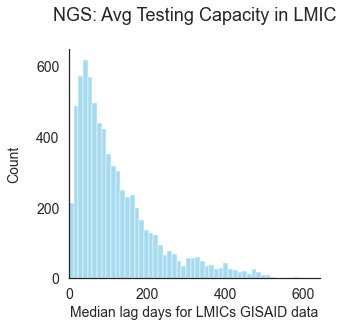

In [99]:
title = "NGS: Avg Testing Capacity in LMIC"

#formatting of the barchart
figsize = (24, 15)
sns.set(font_scale=1.6)
sns.set_style("white")
sns.despine()

sns.displot(LMICs, x="gisaid_lagdays_median", color = 'skyblue')


plt.title(title, size = 18, y=1.1)
plt.xlabel("Median lag days for LMICs GISAID data", 
           size = 14)
plt.ylabel("Count",
           size = 14,
          labelpad = axis_pad )
plt.tight_layout()

plt.xticks(size = 14) #size of the words
plt.yticks(size = 14)
plt.xlim((0, None))

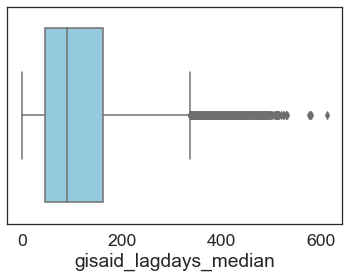

In [101]:
ax = sns.boxplot(x=LMICs["gisaid_lagdays_median"], color = 'skyblue')

(0.0, 642.6)

<Figure size 432x288 with 0 Axes>

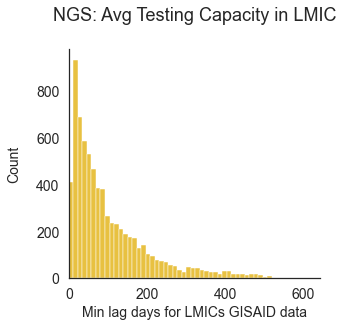

In [105]:
title = "NGS: Avg Testing Capacity in LMIC"

#formatting of the barchart
figsize = (24, 15)
sns.set(font_scale=1.6)
sns.set_style("white")
sns.despine()

sns.displot(LMICs, x="gisaid_lagdays_min", color = '#E1AD01')


plt.title(title, size = 18, y=1.1)
plt.xlabel("Min lag days for LMICs GISAID data", 
           size = 14)
plt.ylabel("Count",
           size = 14,
          labelpad = axis_pad )
plt.tight_layout()

plt.xticks(size = 14) #size of the words
plt.yticks(size = 14)
plt.xlim((0, None))

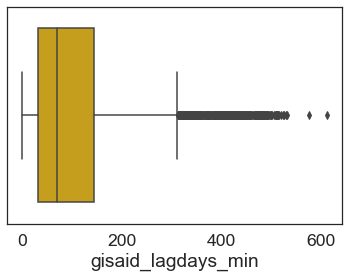

In [106]:
ax = sns.boxplot(x=LMICs["gisaid_lagdays_min"], color = '#E1AD01')

In [107]:
#observe what the median number of lagdays are among all countries...
LMICs.gisaid_lagdays_min.median()

69.0

# Global rolling-averages (14, 30, 45, 60 days)

In [196]:
merged_pivoted_df_latest.head(2)

,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3,seq_difference
0,2019-12-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2019-12-26,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
LMICs.head(2)

,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_yearweek,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3
0,2019-12-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-24,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-W52,2019-12-23,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
Global_gisaid_daily = merged_pivoted_df_latest.groupby('gisaid_country').apply(lambda x: x.set_index('gisaid_collect_date').resample('1D').first())
Global_gisaid_daily.head()

gisaid_country  All lineages  AY.1  AY.10  \
gisaid_country gisaid_collect_date                                             
Afghanistan    2019-12-24             Afghanistan           NaN   NaN    NaN   
               2019-12-25                    None           NaN   NaN    NaN   
               2019-12-26             Afghanistan           NaN   NaN    NaN   
               2019-12-27                    None           NaN   NaN    NaN   
               2019-12-28                    None           NaN   NaN    NaN   

                                    AY.11  AY.12  AY.13  AY.14  AY.15  AY.16  \
gisaid_country gisaid_collect_date                                             
Afghanistan    2019-12-24             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-25             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-26             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-27             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-28             NaN    NaN    NaN    NaN    NaN    NaN   

                                    ...  gisaid_collect_weekstartdate  \
gisaid_country gisaid_collect_date  ...                                 
Afghanistan    2019-12-24           ...                    2019-12-23   
               2019-12-25           ...                           NaT   
               2019-12-26           ...                    2019-12-23   
               2019-12-27           ...                           NaT   
               2019-12-28           ...                           NaT   

                                               who_region  aggregate_location  \
gisaid_country gisaid_collect_date                                              
Afghanistan    2019-12-24           Eastern Mediterranean                None   
               2019-12-25                            None                None   
               2019-12-26           Eastern Mediterranean                None   
               2019-12-27                            None                None   
               2019-12-28                            None                None   

                                    seq_count  gisaid_lagdays_median  \
gisaid_country gisaid_collect_date                                     
Afghanistan    2019-12-24                 NaN                    NaN   
               2019-12-25                 NaN                    NaN   
               2019-12-26                 NaN                    NaN   
               2019-12-27                 NaN                    NaN   
               2019-12-28                 NaN                    NaN   

                                    gisaid_lagdays_min  gisaid_lagdays_max  \
gisaid_country gisaid_collect_date                                           
Afghanistan    2019-12-24                          NaN                 NaN   
               2019-12-25                          NaN                 NaN   
               2019-12-26                          NaN                 NaN   
               2019-12-27                          NaN                 NaN   
               2019-12-28                          NaN                 NaN   

                                    gisaid_lagdays_q1  gisaid_lagdays_q3  \
gisaid_country gisaid_collect_date                                         
Afghanistan    2019-12-24                         NaN                NaN   
               2019-12-25                         NaN                NaN   
               2019-12-26                         NaN                NaN   
               2019-12-27                         NaN                NaN   
               2019-12-28                         NaN                NaN   

                                    seq_difference  
gisaid_country gisaid_collect_date                  
Afghanistan    2019-12-24                      NaN  
               2019-12-25                      NaN  
               2019-12-26           

In [200]:
LMIC_gisaid_daily = LMICs.groupby('gisaid_country').apply(lambda x: x.set_index('gisaid_collect_date').resample('1D').first())
LMIC_gisaid_daily.head()

gisaid_country  All lineages  AY.1  AY.10  \
gisaid_country gisaid_collect_date                                             
Afghanistan    2019-12-24             Afghanistan           NaN   NaN    NaN   
               2019-12-25                    None           NaN   NaN    NaN   
               2019-12-26             Afghanistan           NaN   NaN    NaN   
               2019-12-27                    None           NaN   NaN    NaN   
               2019-12-28                    None           NaN   NaN    NaN   

                                    AY.11  AY.12  AY.13  AY.14  AY.15  AY.16  \
gisaid_country gisaid_collect_date                                             
Afghanistan    2019-12-24             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-25             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-26             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-27             NaN    NaN    NaN    NaN    NaN    NaN   
               2019-12-28             NaN    NaN    NaN    NaN    NaN    NaN   

                                    ...  gisaid_collect_yearweek  \
gisaid_country gisaid_collect_date  ...                            
Afghanistan    2019-12-24           ...                 2019-W52   
               2019-12-25           ...                     None   
               2019-12-26           ...                 2019-W52   
               2019-12-27           ...                     None   
               2019-12-28           ...                     None   

                                    gisaid_collect_weekstartdate  \
gisaid_country gisaid_collect_date                                 
Afghanistan    2019-12-24                             2019-12-23   
               2019-12-25                                    NaT   
               2019-12-26                             2019-12-23   
               2019-12-27                                    NaT   
               2019-12-28                                    NaT   

                                               who_region  aggregate_location  \
gisaid_country gisaid_collect_date                                              
Afghanistan    2019-12-24           Eastern Mediterranean                None   
               2019-12-25                            None                None   
               2019-12-26           Eastern Mediterranean                None   
               2019-12-27                            None                None   
               2019-12-28                            None                None   

                                    seq_count  gisaid_lagdays_median  \
gisaid_country gisaid_collect_date                                     
Afghanistan    2019-12-24                 NaN                    NaN   
               2019-12-25                 NaN                    NaN   
               2019-12-26                 NaN                    NaN   
               2019-12-27                 NaN                    NaN   
               2019-12-28                 NaN                    NaN   

                                    gisaid_lagdays_min  gisaid_lagdays_max  \
gisaid_country gisaid_collect_date                                           
Afghanistan    2019-12-24                          NaN                 NaN   
               2019-12-25                          NaN                 NaN   
               2019-12-26                          NaN                 NaN   
               2019-12-27                          NaN                 NaN   
               2019-12-28                          NaN                 NaN   

                                    gisaid_lagdays_q1  gisaid_lagdays_q3  
gisaid_country gisaid_collect_date                                        
Afghanistan    2019-12-24                         NaN                NaN  
               2019-12-25                         NaN                NaN  
               2019-12-26              

In [ ]:
#Observing Global sequencing by 14-day, 30-day, 45-day, and 60-day rolling average

In [203]:
Global_sequ_14_rolling_avg = Global_gisaid_daily.groupby(level=0)['seq_count'].apply(lambda x: x.shift().rolling(min_periods=1,window=14).mean()).reset_index(name='sequ_14_rolling')    
Global_sequ_14_rolling_avg.head()

,gisaid_country,gisaid_collect_date,sequ_14_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [207]:
Global_cases_14_rolling_avg = Global_gisaid_daily.groupby(level=0)['owid_new_cases_smoothed'].apply(lambda x: x.shift().rolling(min_periods=1,window=14).mean()).reset_index(name='cases_14_rolling')    
Global_cases_14_rolling_avg.head()

,gisaid_country,gisaid_collect_date,cases_14_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [209]:
Global_14_rolling = pd.merge (Global_sequ_14_rolling_avg, Global_cases_14_rolling_avg, 
                      on = ['gisaid_collect_date', 'gisaid_country'])
Global_14_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_14_rolling,cases_14_rolling
0,Afghanistan,2019-12-24,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN


In [ ]:
#Observing 30 day rolling average

In [204]:
Global_sequ_30_rolling_avg = Global_gisaid_daily.groupby(level=0)['seq_count'].apply(lambda x: x.shift().rolling(min_periods=1,window=30).mean()).reset_index(name='sequ_30_rolling')    
Global_sequ_30_rolling_avg.head()

,gisaid_country,gisaid_collect_date,sequ_30_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [214]:
Global_cases_30_rolling_avg = Global_gisaid_daily.groupby(level=0)['owid_new_cases_smoothed'].apply(lambda x: x.shift().rolling(min_periods=1,window=30).mean()).reset_index(name='cases_30_rolling')    
Global_cases_30_rolling_avg.head()

,gisaid_country,gisaid_collect_date,cases_30_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [215]:
Global_30_rolling = pd.merge (Global_sequ_30_rolling_avg, Global_cases_30_rolling_avg, 
                      on = ['gisaid_collect_date', 'gisaid_country'])
Global_30_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_30_rolling,cases_30_rolling
0,Afghanistan,2019-12-24,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN


In [ ]:
#45 rolling day average

In [205]:
Global_sequ_45_rolling_avg = Global_gisaid_daily.groupby(level=0)['seq_count'].apply(lambda x: x.shift().rolling(min_periods=1,window=45).mean()).reset_index(name='sequ_45_rolling')    
Global_sequ_45_rolling_avg.head()

,gisaid_country,gisaid_collect_date,sequ_45_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [217]:
Global_cases_45_rolling_avg = Global_gisaid_daily.groupby(level=0)['owid_new_cases_smoothed'].apply(lambda x: x.shift().rolling(min_periods=1,window=45).mean()).reset_index(name='cases_45_rolling')    
Global_cases_45_rolling_avg.head()

,gisaid_country,gisaid_collect_date,cases_45_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [218]:
Global_45_rolling = pd.merge (Global_sequ_45_rolling_avg, Global_cases_45_rolling_avg, 
                      on = ['gisaid_collect_date', 'gisaid_country'])
Global_45_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_45_rolling,cases_45_rolling
0,Afghanistan,2019-12-24,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN


In [ ]:
#Observing 60-day rolling average

In [231]:
Global_sequ_60_rolling_avg = Global_gisaid_daily.groupby(level=0)['seq_count'].apply(lambda x: x.shift().rolling(min_periods=1,window=60).mean()).reset_index(name='sequ_60_rolling')    
Global_sequ_60_rolling_avg.head()

,gisaid_country,gisaid_collect_date,sequ_60_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [232]:
Global_cases_60_rolling_avg = Global_gisaid_daily.groupby(level=0)['owid_new_cases_smoothed'].apply(lambda x: x.shift().rolling(min_periods=1,window=60).mean()).reset_index(name='cases_60_rolling')    
Global_cases_60_rolling_avg.head()

,gisaid_country,gisaid_collect_date,cases_60_rolling
0,Afghanistan,2019-12-24,NaN
1,Afghanistan,2019-12-25,NaN
2,Afghanistan,2019-12-26,NaN
3,Afghanistan,2019-12-27,NaN
4,Afghanistan,2019-12-28,NaN


In [234]:
Global_60_rolling = pd.merge (Global_sequ_60_rolling_avg, Global_cases_60_rolling_avg, 
                      on = ['gisaid_collect_date', 'gisaid_country'])
Global_60_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_60_rolling,cases_60_rolling
0,Afghanistan,2019-12-24,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN


In [ ]:
#Computing the % of new weekly sequencing by COVID-19 cases, by country

In [210]:
#14-day rolling sequencing incidence, per 100K COVID19 cases
Global_14_rolling['sequ_cases_rate_100'] = Global_14_rolling['sequ_14_rolling']/Global_14_rolling['cases_14_rolling']*100
Global_14_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_14_rolling,cases_14_rolling,sequ_cases_rate_100
0,Afghanistan,2019-12-24,NaN,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN,NaN


In [216]:
#30-day rolling sequencing incidence, per 100K COVID19 cases
Global_30_rolling['sequ_cases_rate_100'] = Global_30_rolling['sequ_30_rolling']/Global_30_rolling['cases_30_rolling']*100
Global_30_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_30_rolling,cases_30_rolling,sequ_cases_rate_100
0,Afghanistan,2019-12-24,NaN,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN,NaN


In [226]:
#45-day rolling sequencing incidence, per 100K COVID19 cases
Global_45_rolling['sequ_cases_rate_100'] = Global_45_rolling['sequ_45_rolling']/Global_45_rolling['cases_45_rolling']*100
Global_45_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_45_rolling,cases_45_rolling,sequ_cases_rate_100
0,Afghanistan,2019-12-24,NaN,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN,NaN


In [235]:
#60-day rolling sequencing incidence, per 100K COVID19 cases
Global_60_rolling['sequ_cases_rate_100'] = Global_60_rolling['sequ_60_rolling']/Global_60_rolling['cases_60_rolling']*100
Global_60_rolling.head()

,gisaid_country,gisaid_collect_date,sequ_60_rolling,cases_60_rolling,sequ_cases_rate_100
0,Afghanistan,2019-12-24,NaN,NaN,NaN
1,Afghanistan,2019-12-25,NaN,NaN,NaN
2,Afghanistan,2019-12-26,NaN,NaN,NaN
3,Afghanistan,2019-12-27,NaN,NaN,NaN
4,Afghanistan,2019-12-28,NaN,NaN,NaN


In [ ]:

#Observing trends in the last 30 days


In [266]:
#Only include last 30 days, 14 day rolling average

start_date = "2021-09-21"
end_date = "2021-10-21"

#sub-analysis of specific dates, building off of map data "no_VI"
after_start_date = Global_14_rolling["gisaid_collect_date"] >= start_date
before_end_date = Global_14_rolling["gisaid_collect_date"] <= end_date
between_two_dates = after_start_date & before_end_date
Global_14_rolling_past30_days = Global_14_rolling.loc[between_two_dates]
Global_14_rolling_past30_days.head()

,gisaid_country,gisaid_collect_date,sequ_14_rolling,cases_14_rolling,sequ_cases_rate_100
637,Afghanistan,2021-09-21,NaN,75.071500,NaN
638,Afghanistan,2021-09-22,NaN,76.357214,NaN
639,Afghanistan,2021-09-23,NaN,76.336786,NaN
640,Afghanistan,2021-09-24,NaN,75.367357,NaN
641,Afghanistan,2021-09-25,NaN,74.204071,NaN


In [267]:
#Only include last 30 days, 30 day rolling average

start_date = "2021-09-21"
end_date = "2021-10-21"

#sub-analysis of specific dates, building off of map data "no_VI"
after_start_date = Global_30_rolling["gisaid_collect_date"] >= start_date
before_end_date = Global_30_rolling["gisaid_collect_date"] <= end_date
between_two_dates = after_start_date & before_end_date
Global_30_rolling_past30_days = Global_30_rolling.loc[between_two_dates]
Global_30_rolling_past30_days.head()

,gisaid_country,gisaid_collect_date,sequ_30_rolling,cases_30_rolling,sequ_cases_rate_100
637,Afghanistan,2021-09-21,NaN,70.157167,NaN
638,Afghanistan,2021-09-22,NaN,70.414300,NaN
639,Afghanistan,2021-09-23,NaN,70.571433,NaN
640,Afghanistan,2021-09-24,NaN,70.676200,NaN
641,Afghanistan,2021-09-25,NaN,71.219033,NaN


In [268]:
#Only include last 30 days, 45 day rolling average

start_date = "2021-09-21"
end_date = "2021-10-21"

#sub-analysis of specific dates, building off of map data "no_VI"
after_start_date = Global_45_rolling["gisaid_collect_date"] >= start_date
before_end_date = Global_45_rolling["gisaid_collect_date"] <= end_date
between_two_dates = after_start_date & before_end_date
Global_45_rolling_past30_days = Global_45_rolling.loc[between_two_dates]
Global_45_rolling_past30_days.head()

,gisaid_country,gisaid_collect_date,sequ_45_rolling,cases_45_rolling,sequ_cases_rate_100
637,Afghanistan,2021-09-21,NaN,131.917467,NaN
638,Afghanistan,2021-09-22,NaN,123.809533,NaN
639,Afghanistan,2021-09-23,NaN,115.926978,NaN
640,Afghanistan,2021-09-24,NaN,108.453956,NaN
641,Afghanistan,2021-09-25,NaN,102.206333,NaN


In [269]:
#Only include last 30 days, 45 day rolling average

start_date = "2021-09-21"
end_date = "2021-10-21"

#sub-analysis of specific dates, building off of map data "no_VI"
after_start_date = Global_60_rolling["gisaid_collect_date"] >= start_date
before_end_date = Global_60_rolling["gisaid_collect_date"] <= end_date
between_two_dates = after_start_date & before_end_date
Global_60_rolling_past30_days = Global_60_rolling.loc[between_two_dates]
Global_60_rolling_past30_days.head()

,gisaid_country,gisaid_collect_date,sequ_60_rolling,cases_60_rolling,sequ_cases_rate_100
637,Afghanistan,2021-09-21,NaN,216.988050,NaN
638,Afghanistan,2021-09-22,NaN,207.807100,NaN
639,Afghanistan,2021-09-23,NaN,200.740433,NaN
640,Afghanistan,2021-09-24,NaN,194.002333,NaN
641,Afghanistan,2021-09-25,NaN,188.495183,NaN


In [ ]:

#Visualizing the Global Trends of each average, in the last 30, 60, 90 days


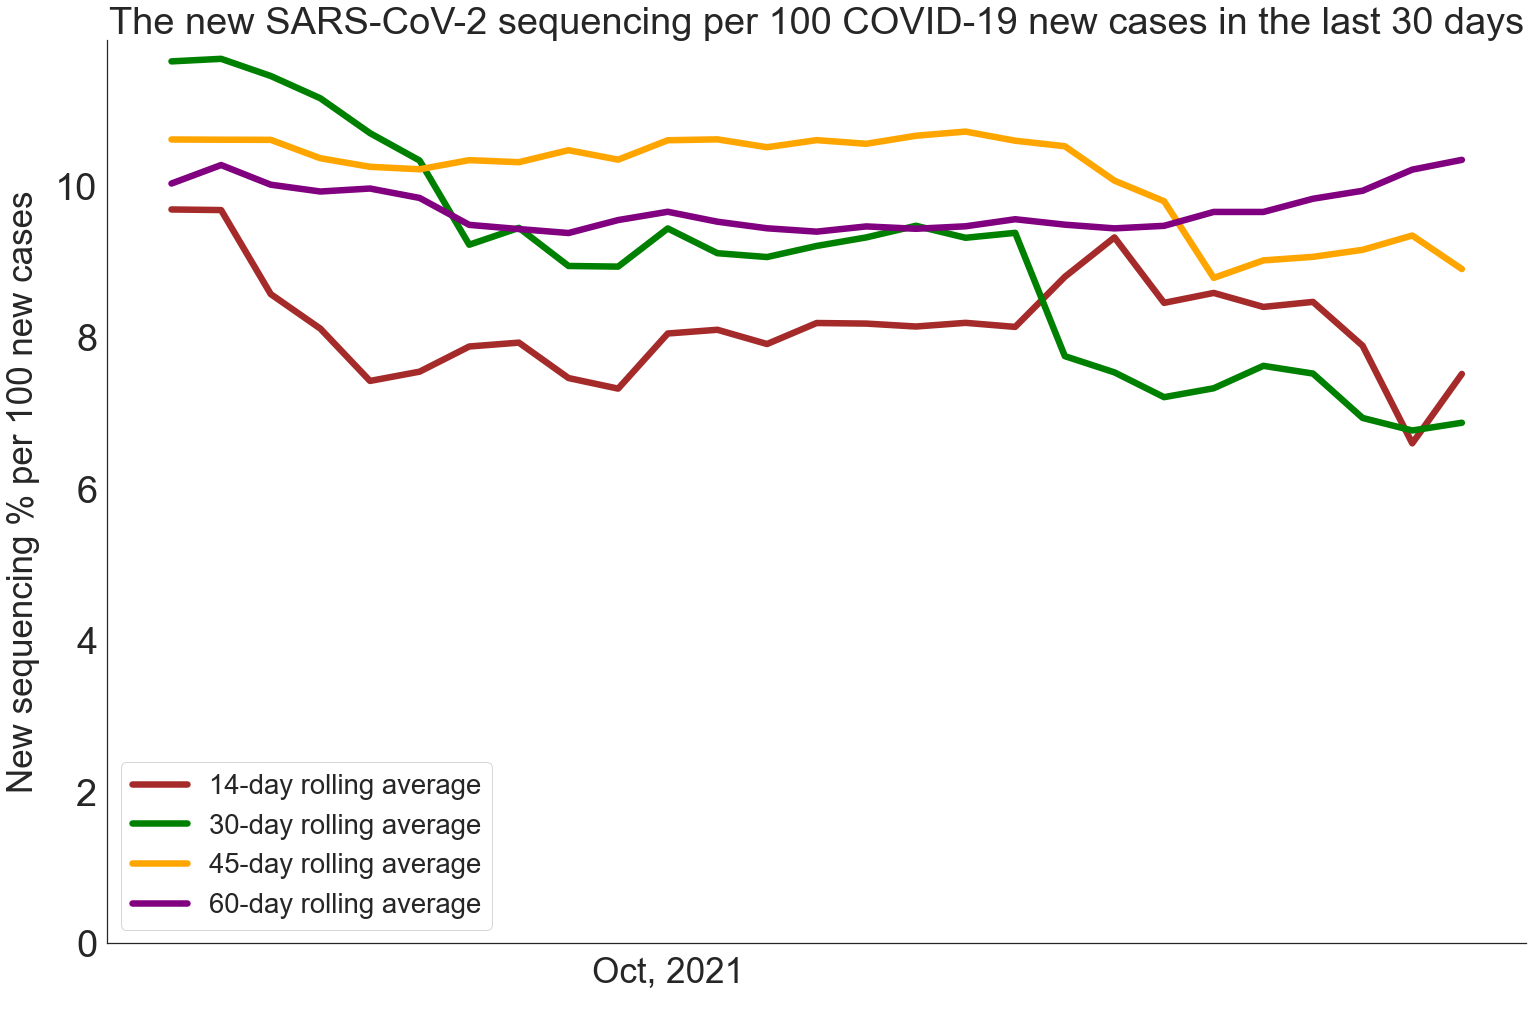

In [270]:
#using visualization template

#*********************************************************************
# Figure 3: LMIC trend of percent change of SARS-2 genomic sequencing proportions (%).
#*********************************************************************

from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import calendar
import matplotlib.ticker as ticker

#title and formatting
title = "The new SARS-CoV-2 sequencing per 100 COVID-19 new cases in the last 30 days"
sns.set(font_scale=font_size_var,rc={"lines.linewidth": 6.5},)
sns.set_style("white")
#fig, ax = plt.subplots(figsize=(figure_size))
fig, ax = plt.subplots(1,figsize=(22, 15))

#plotting global trends
sns.lineplot(x="gisaid_collect_date", y="sequ_cases_rate_100", ci = None, color = 'brown',
             label = '14-day rolling average', data=Global_14_rolling_past30_days)

sns.lineplot(x="gisaid_collect_date", y="sequ_cases_rate_100", ci = None, color = 'green',
              label = '30-day rolling average', data=Global_30_rolling_past30_days)

sns.lineplot(x="gisaid_collect_date", y="sequ_cases_rate_100", ci = None, color = 'orange',
              label = '45-day rolling average', data=Global_45_rolling_past30_days)

sns.lineplot(x="gisaid_collect_date", y="sequ_cases_rate_100", ci = None, color = 'purple',
              label = '60-day rolling average', data=Global_60_rolling_past30_days)

 
plt.title(title, size = 38)
plt.xlabel(" ")
plt.ylabel("New sequencing % per 100 new cases", 
           size = 35, labelpad = axis_pad )

plt.ylim((0, None))

plt.xticks(size = 35)
plt.yticks(size = 38)

ax.tick_params(axis = 'x', which = 'major', length = 10, size = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5, size = 10)

#Make the legend outside of the chart, and the legend centered
#handles, labels = ax.get_legend_handles_labels()

#ax.legend((handles), (labels), loc='lower left', bbox_to_anchor=(1.0, 0.5), frameon=False
#         , title="Rolling averages", prop={"size":28})



#ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b, %Y"))


#plt.figtext(0.5, 0.01, "**Last few months of data, from 06/2021 and forward ", ha="center", fontsize=30, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


sns.despine()
plt.tight_layout()

#plt.xticks(rotation = 'vertical')
#plt.savefig(title + ".png", dpi=500, facecolor='w', 
           # edgecolor='w', 
            #orientation='portrait')


In [271]:
#past 30 days
start_date = "2021-09-21"
end_date = "2021-10-21"

#sub-analysis of specific dates, building off of map data "no_VI"
after_start_date = merged_pivoted_df_latest["gisaid_collect_date"] >= start_date
before_end_date = merged_pivoted_df_latest["gisaid_collect_date"] <= end_date
between_two_dates = after_start_date & before_end_date
Global_seq_past30_days = merged_pivoted_df_latest.loc[between_two_dates]
Global_seq_past30_days.head()

,gisaid_collect_date,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,AY.15,...,gisaid_collect_weekstartdate,who_region,aggregate_location,seq_count,gisaid_lagdays_median,gisaid_lagdays_min,gisaid_lagdays_max,gisaid_lagdays_q1,gisaid_lagdays_q3,seq_difference
155085,2021-09-21,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-20,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155330,2021-09-22,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-20,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155575,2021-09-23,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-20,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155820,2021-09-24,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-20,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156065,2021-09-25,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-09-20,Eastern Mediterranean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
#aggregation by date and country
Global_seq_sum_30_days = Global_seq_past30_days.groupby([ 'gisaid_collect_date', 'gisaid_country'])['seq_count'].sum().reset_index()
Global_seq_sum_30_days.head()

,gisaid_collect_date,gisaid_country,seq_count
0,2021-09-21,Afghanistan,0.0
1,2021-09-21,Albania,0.0
2,2021-09-21,Algeria,0.0
3,2021-09-21,Andorra,0.0
4,2021-09-21,Angola,0.0


In [273]:
#45-day rolling sequencing incidence, per 100K COVID19 cases
Global_seq_sum_30_days['daily_sequencing'] = (Global_seq_sum_30_days['seq_count']/30)*100
Global_seq_sum_30_days.head()

,gisaid_collect_date,gisaid_country,seq_count,daily_sequencing
0,2021-09-21,Afghanistan,0.0,0.0
1,2021-09-21,Albania,0.0,0.0
2,2021-09-21,Algeria,0.0,0.0
3,2021-09-21,Andorra,0.0,0.0
4,2021-09-21,Angola,0.0,0.0


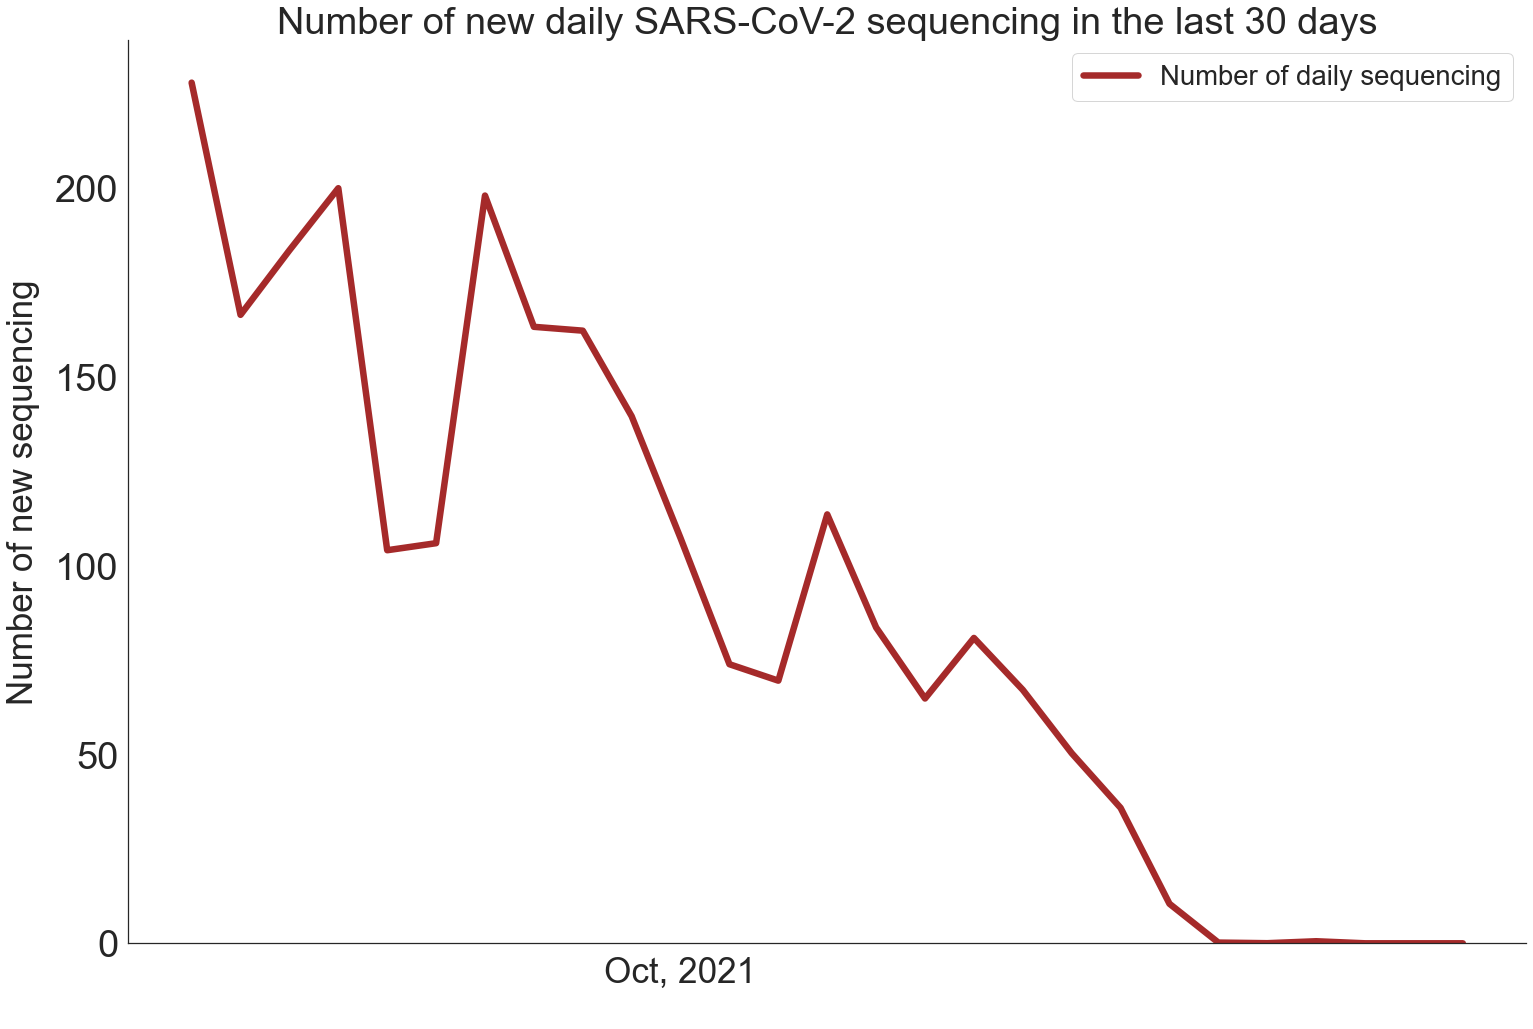

In [277]:
#using visualization template

#*********************************************************************
# Figure 3: LMIC trend of percent change of SARS-2 genomic sequencing proportions (%).
#*********************************************************************

from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import calendar
import matplotlib.ticker as ticker

#title and formatting
title = "Number of new daily SARS-CoV-2 sequencing in the last 30 days"
sns.set(font_scale=font_size_var,rc={"lines.linewidth": 6.5},)
sns.set_style("white")
#fig, ax = plt.subplots(figsize=(figure_size))
fig, ax = plt.subplots(1,figsize=(22, 15))

#plotting global trends
sns.lineplot(x="gisaid_collect_date", y="daily_sequencing", ci = None, color = 'brown',
            label = "Number of daily sequencing", data=Global_seq_sum_30_days)

 
plt.title(title, size = 38)
plt.xlabel(" ")
plt.ylabel("Number of new sequencing", 
           size = 35, labelpad = axis_pad )

plt.ylim((0, None))

plt.xticks(size = 35)
plt.yticks(size = 38)

ax.tick_params(axis = 'x', which = 'major', length = 10, size = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5, size = 10)

#Make the legend outside of the chart, and the legend centered
#handles, labels = ax.get_legend_handles_labels()

#ax.legend((handles), (labels), loc='lower left', bbox_to_anchor=(1.0, 0.5), frameon=False
#         , title="Rolling averages", prop={"size":28})



#ax.xaxis.set_visible(True) 
ax.xaxis.set_major_locator(md.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b, %Y"))


#plt.figtext(0.5, 0.01, "**Last few months of data, from 06/2021 and forward ", ha="center", fontsize=30, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


sns.despine()
plt.tight_layout()

#plt.xticks(rotation = 'vertical')
#plt.savefig(title + ".png", dpi=500, facecolor='w', 
           # edgecolor='w', 
            #orientation='portrait')


In [ ]:
#observing LMIC rolling averages

In [ ]:
LMIC_FIND_month_seq = LMIC_gisaid_daily.groupby(level=0)['pop_100k'].apply(lambda x: x.shift().rolling(min_periods=1,window=90).mean()).reset_index(name='pop_Average_Past_90_days')    
LMIC_FIND_month_seq.head()

In [ ]:

LMIC_gisaid_month_cases = LMIC_gisaid_daily.groupby(level=0)['owid_new_cases_smoothed'].apply(lambda x: x.shift().rolling(min_periods=1,window=90).mean()).reset_index(name='test_Average_Past_90_days') 
LMIC_gisaid_month_cases.head()

In [ ]:
LMIC_test1 = pd.merge (LMIC_FIND_month_seq, LMIC_gisaid_month, 
                      on = ['date', 'country'])
LMIC_test1.head()

In [ ]:
LMIC_test1

In [102]:
#read in Aug data
df_FIND = pd.read_csv ("https://raw.githubusercontent.com/dsbbfinddx/FINDCov19TrackerData/master/processed/data_all.csv")
# all_new_tests: Daily number of tests (7 day rolling average smoothed)
df_FIND.head(3)

,set,name,unit,time,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_deaths,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos
0,country,United States,USA,2020-01-18,4.0,4.0,3310.03,NaN,NaN,NaN,...,NaN,0.001208,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
1,income,NaN,High,2020-01-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001208,NaN,0.0,0.0,0.0,0.0,4,0.0,NaN
2,region,NaN,North America,2020-01-18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001208,NaN,0.0,0.0,0.0,0.0,4,0.0,NaN


In [108]:
#assess those with "country" in set

Country_Subset = df_FIND.loc[(df_FIND['set'] == 'country')]
Country_Subset.head(4)

,set,name,unit,time,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_deaths,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos
0,country,United States,USA,2020-01-18,4.0,4.0,3310.03,NaN,NaN,NaN,...,NaN,0.001208,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
4,country,United States,USA,2020-01-19,4.0,0.0,3310.03,NaN,NaN,NaN,...,NaN,0.002417,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN
8,country,United States,USA,2020-01-20,11.0,7.0,3310.03,NaN,NaN,NaN,...,NaN,0.003323,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN
12,country,Taiwan,TWN,2020-01-21,12.0,12.0,238.17,NaN,NaN,NaN,...,NaN,0.050384,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN


In [109]:
print (Country_Subset.columns.unique())

Index(['set', 'name', 'unit', 'time', 'cum_tests_orig', 'new_tests_orig',
       'pop_100k', 'new_cases_orig', 'new_deaths_orig', 'cap_cum_cases',
       'cap_new_cases', 'cap_cum_deaths', 'cap_new_deaths', 'cap_cum_tests',
       'cap_new_tests', 'all_cum_cases', 'all_new_cases', 'all_cum_deaths',
       'all_new_deaths', 'all_cum_tests', 'all_new_tests', 'pos'],
      dtype='object')

In [112]:
#melt dataframe
#melting the dataframe to turn the dates from wide format to long format
Country_Subset.rename(columns={'name': 'country',}, inplace = True)
Country_Subset.rename(columns={'time': 'date',}, inplace = True)
Country_Subset.head(5)

C:\Users\bthrift\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_deaths,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos
0,country,United States,USA,2020-01-18,4.0,4.0,3310.03,NaN,NaN,NaN,...,NaN,0.001208,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
4,country,United States,USA,2020-01-19,4.0,0.0,3310.03,NaN,NaN,NaN,...,NaN,0.002417,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN
8,country,United States,USA,2020-01-20,11.0,7.0,3310.03,NaN,NaN,NaN,...,NaN,0.003323,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN
12,country,Taiwan,TWN,2020-01-21,12.0,12.0,238.17,NaN,NaN,NaN,...,NaN,0.050384,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN
13,country,United States,USA,2020-01-21,14.0,3.0,3310.03,NaN,NaN,NaN,...,NaN,0.004230,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN


In [115]:
Country_Subset.sort_values(by=['country','date'], ascending=True, inplace=True)
Country_Subset.head(4)

<ipython-input-115-d43eff069518>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_Subset.sort_values(by=['country','date'], ascending=True, inplace=True)


,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_deaths,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos
18,country,Afghanistan,AFG,2020-01-22,NaN,NaN,389.28,NaN,NaN,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
224,country,Afghanistan,AFG,2020-01-23,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
430,country,Afghanistan,AFG,2020-01-24,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
636,country,Afghanistan,AFG,2020-01-25,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN


In [116]:
Country_Subset.date.unique()

array(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
       '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
       '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
       '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
       '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
       '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
       '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
       '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
       '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
       '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
       '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
       '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
       '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-23', '2020-03-24', '2020-

In [117]:
#Only look at LMIC's

LMIC_FIND = Country_Subset[Country_Subset.country.isin([
    'Afghanistan','Guinea-Bissau', 'Somalia'
    'Burkina Faso', "Korea Dem. People's Rep" , 'South Sudan',
    'Burundi', 'Liberia', 'Sudan',
    'Central African Republic', 'Madagascar', 'Chad', 'Malawi', 'Togo',
    'Democratic Republic of the Congo', 'Mali', 'Uganda',
    'Mozambique','Ethiopia', 'Niger', 
    'Gambia, The', 'Rwanda', 
    'Guinea', 'Sierra Leone', 'Angola','Honduras', 'Philippines',
    'Algeria', 'India', 'Samoa','Bangladesh', 'Indonesia',
    'Belize', 'Iran', 'Senegal', 'Benin', 'Kenya', 'Solomon Islands',
    'Sri Lanka','Bolivia','Tanzania','Cabo Verde', 'Laos','Cambodia', 
    'Lesotho', 'Timor-Leste','Cameroon', 'Tunisia', 'Comoros', 'Ukraine', 
    'Republic of the Congo', 'Mongolia', 'Uzbekistan',"Côte d'Ivoire", 
    'Morocco', 'Vanuatu','Djibouti', 'Myanmar', 'Vietnam','Egypt', 'Nepal', 
    'El Salvador', 'Zambia','Eswatini', 'Nigeria', 'Zimbabwe','Ghana',
    'Pakistan', 'Haiti', 'Papua New Guinea'])]
print ("LMICs:",LMIC_FIND.country.nunique())
LMIC_FIND.head(3)

LMICs: 60


,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_deaths,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos
18,country,Afghanistan,AFG,2020-01-22,NaN,NaN,389.28,NaN,NaN,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
224,country,Afghanistan,AFG,2020-01-23,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN
430,country,Afghanistan,AFG,2020-01-24,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN


In [120]:
#observe what the median number of lagdays are among all countries...
LMIC_FIND.all_new_tests.median()

LMIC_FIND['new_test_by_pop'] = LMIC_FIND['all_new_tests']/LMIC_FIND['pop_100k']
#7-day rolling testing incidence, per 100K population
LMIC_FIND.head()

<ipython-input-120-94d7af6b29e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMIC_FIND['new_test_by_pop'] = LMIC_FIND['all_new_tests']/LMIC_FIND['pop_100k']


,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_cum_tests,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos,new_test_by_pop
18,country,Afghanistan,AFG,2020-01-22,NaN,NaN,389.28,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN
224,country,Afghanistan,AFG,2020-01-23,NaN,NaN,389.28,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN
430,country,Afghanistan,AFG,2020-01-24,NaN,NaN,389.28,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN
636,country,Afghanistan,AFG,2020-01-25,NaN,NaN,389.28,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN
842,country,Afghanistan,AFG,2020-01-26,NaN,NaN,389.28,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN


In [121]:
#observe what the median number of lagdays are among all countries...
LMIC_FIND.new_test_by_pop.median()

8.038657533387623

In [ ]:
LMIC_FIND.new_test_by_pop.median()

In [123]:
LMIC_FIND['date'] = pd.to_datetime(LMIC_FIND['date'])
LMIC_FIND.dtypes

<ipython-input-123-e5565e7299c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMIC_FIND['date'] = pd.to_datetime(LMIC_FIND['date'])


set                        object
country                    object
unit                       object
date               datetime64[ns]
cum_tests_orig            float64
new_tests_orig            float64
pop_100k                  float64
new_cases_orig            float64
new_deaths_orig           float64
cap_cum_cases             float64
cap_new_cases             float64
cap_cum_deaths            float64
cap_new_deaths            float64
cap_cum_tests             float64
cap_new_tests             float64
all_cum_cases             float64
all_new_cases             float64
all_cum_deaths            float64
all_new_deaths            float64
all_cum_tests               int64
all_new_tests             float64
pos                       float64
new_test_by_pop           float64
dtype: object

In [124]:
LMIC_FIND['month'] = pd.DatetimeIndex(LMIC_FIND['date']).month
LMIC_FIND.head()

<ipython-input-124-b297fa901e14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMIC_FIND['month'] = pd.DatetimeIndex(LMIC_FIND['date']).month


,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos,new_test_by_pop,month
18,country,Afghanistan,AFG,2020-01-22,NaN,NaN,389.28,NaN,NaN,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
224,country,Afghanistan,AFG,2020-01-23,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
430,country,Afghanistan,AFG,2020-01-24,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
636,country,Afghanistan,AFG,2020-01-25,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
842,country,Afghanistan,AFG,2020-01-26,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1


In [126]:
monthly_LMIC_test_Pop = LMIC_FIND.groupby([ 'month', 'country'])['all_new_tests', 'pop_100k' ].mean().reset_index()
monthly_LMIC_test_Pop.head()

<ipython-input-126-cc3d11bbd5da>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_LMIC_test_Pop = LMIC_FIND.groupby([ 'month', 'country'])['all_new_tests', 'pop_100k' ].mean().reset_index()


,month,country,all_new_tests,pop_100k
0,1,Afghanistan,1470.096774,389.28
1,1,Algeria,NaN,438.51
2,1,Angola,1492.774194,328.66
3,1,Bangladesh,13976.419355,1646.89
4,1,Belize,241.032258,3.98


In [127]:
#print (monthly_LMIC_test_Pop.all_new_tests.median())

monthly_LMIC_test_Pop['new_test_by_pop'] = monthly_LMIC_test_Pop['all_new_tests']/monthly_LMIC_test_Pop['pop_100k']
#monthly testing incidence, per 100K population
monthly_LMIC_test_Pop.head()

,month,country,all_new_tests,pop_100k,new_test_by_pop
0,1,Afghanistan,1470.096774,389.28,3.776451
1,1,Algeria,NaN,438.51,NaN
2,1,Angola,1492.774194,328.66,4.542001
3,1,Bangladesh,13976.419355,1646.89,8.486553
4,1,Belize,241.032258,3.98,60.560869


In [128]:
monthly_LMIC_test_Pop.new_test_by_pop.median()

9.403606972007108

In [132]:
LMIC_FIND.head()

,set,country,unit,date,cum_tests_orig,new_tests_orig,pop_100k,new_cases_orig,new_deaths_orig,cap_cum_cases,...,cap_new_tests,all_cum_cases,all_new_cases,all_cum_deaths,all_new_deaths,all_cum_tests,all_new_tests,pos,new_test_by_pop,month
18,country,Afghanistan,AFG,2020-01-22,NaN,NaN,389.28,NaN,NaN,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
224,country,Afghanistan,AFG,2020-01-23,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
430,country,Afghanistan,AFG,2020-01-24,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
636,country,Afghanistan,AFG,2020-01-25,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1
842,country,Afghanistan,AFG,2020-01-26,NaN,NaN,389.28,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,NaN,NaN,NaN,1


In [131]:
LMIC_FIND_month = LMIC_FIND.groupby('country').apply(lambda x: x.set_index('date').resample('1D').first())
LMIC_FIND_month.head()

set      country unit  cum_tests_orig  \
country     date                                                    
Afghanistan 2020-01-22  country  Afghanistan  AFG             NaN   
            2020-01-23  country  Afghanistan  AFG             NaN   
            2020-01-24  country  Afghanistan  AFG             NaN   
            2020-01-25  country  Afghanistan  AFG             NaN   
            2020-01-26  country  Afghanistan  AFG             NaN   

                        new_tests_orig  pop_100k  new_cases_orig  \
country     date                                                   
Afghanistan 2020-01-22             NaN    389.28             NaN   
            2020-01-23             NaN    389.28             0.0   
            2020-01-24             NaN    389.28             0.0   
            2020-01-25             NaN    389.28             0.0   
            2020-01-26             NaN    389.28             0.0   

                        new_deaths_orig  cap_cum_cases  cap_new_cases  ...  \
country     date                                                       ...   
Afghanistan 2020-01-22              NaN            0.0            NaN  ...   
            2020-01-23              0.0            0.0            NaN  ...   
            2020-01-24              0.0            0.0            NaN  ...   
            2020-01-25              0.0            0.0            NaN  ...   
            2020-01-26              0.0            0.0            NaN  ...   

                        cap_new_tests  all_cum_cases  all_new_cases  \
country     date                                                      
Afghanistan 2020-01-22            NaN            0.0            NaN   
            2020-01-23            NaN            0.0            NaN   
            2020-01-24            NaN            0.0            NaN   
            2020-01-25            NaN            0.0            NaN   
            2020-01-26            NaN            0.0            NaN   

                        all_cum_deaths  all_new_deaths  all_cum_tests  \
country     date                                                        
Afghanistan 2020-01-22             0.0             NaN              0   
            2020-01-23             0.0             NaN              0   
            2020-01-24             0.0             NaN              0   
            2020-01-25             0.0             NaN              0   
            2020-01-26             0.0             NaN              0   

                        all_new_tests  pos  new_test_by_pop  month  
country     date                                                    
Afghanistan 2020-01-22            NaN  NaN              NaN      1  
            2020-01-23            NaN  NaN              NaN      1  
            2020-01-24            NaN  NaN              NaN      1  
            2020-01-25            NaN  NaN              NaN      1  
            2020-01-26            NaN  NaN              NaN      1  

[5 rows x 23 columns]

In [166]:
LMIC_FIND_month_aggregate = LMIC_FIND_month.groupby(level=0)['pop_100k'].apply(lambda x: x.shift().rolling(min_periods=1,window=90).mean()).reset_index(name='pop_Average_Past_0_days')
LMIC_FIND_month_aggregate.head()

,country,date,pop_Average_Past_90_days
0,Afghanistan,2020-01-22,NaN
1,Afghanistan,2020-01-23,389.28
2,Afghanistan,2020-01-24,389.28
3,Afghanistan,2020-01-25,389.28
4,Afghanistan,2020-01-26,389.28


In [167]:
LMIC_FIND_month_aggregate_test = LMIC_FIND_month.groupby(level=0)['all_new_tests'].apply(lambda x: x.shift().rolling(min_periods=1,window=90).mean()).reset_index(name='test_Average_Past_90_days')
LMIC_FIND_month_aggregate_test.head()

,country,date,test_Average_Past_90_days
0,Afghanistan,2020-01-22,NaN
1,Afghanistan,2020-01-23,NaN
2,Afghanistan,2020-01-24,NaN
3,Afghanistan,2020-01-25,NaN
4,Afghanistan,2020-01-26,NaN


In [168]:
LMIC_test = pd.merge (LMIC_FIND_month_aggregate, LMIC_FIND_month_aggregate_test, 
                      on = ['date', 'country'])
LMIC_test.head()

,country,date,pop_Average_Past_90_days,test_Average_Past_90_days
0,Afghanistan,2020-01-22,NaN,NaN
1,Afghanistan,2020-01-23,389.28,NaN
2,Afghanistan,2020-01-24,389.28,NaN
3,Afghanistan,2020-01-25,389.28,NaN
4,Afghanistan,2020-01-26,389.28,NaN


In [169]:
LMIC_test['month'] = pd.DatetimeIndex(LMIC_test['date']).month
LMIC_test.head()

,country,date,pop_Average_Past_90_days,test_Average_Past_90_days,month
0,Afghanistan,2020-01-22,NaN,NaN,1
1,Afghanistan,2020-01-23,389.28,NaN,1
2,Afghanistan,2020-01-24,389.28,NaN,1
3,Afghanistan,2020-01-25,389.28,NaN,1
4,Afghanistan,2020-01-26,389.28,NaN,1


In [170]:
LMIC_test['new_test_by_pop'] = LMIC_test['test_Average_Past_90_days']/LMIC_test['pop_Average_Past_90_days']
#monthly testing incidence, per 100K population
LMIC_test.head()

,country,date,pop_Average_Past_90_days,test_Average_Past_90_days,month,new_test_by_pop
0,Afghanistan,2020-01-22,NaN,NaN,1,NaN
1,Afghanistan,2020-01-23,389.28,NaN,1,NaN
2,Afghanistan,2020-01-24,389.28,NaN,1,NaN
3,Afghanistan,2020-01-25,389.28,NaN,1,NaN
4,Afghanistan,2020-01-26,389.28,NaN,1,NaN


In [172]:
LMIC_test.new_test_by_pop.median()

7.573736696347628

# Weekly aggregated GISAID data

In [34]:
#Edit dates to make them weekly data

print('Also creating weekly aggregate file...')
weekly_df = aggregate_weekly(merged_pivoted_df_latest)
weekly_df = calc_vax_bottomup(weekly_df, loc_col='owid_location')

print('Calculating weekly lagtime stats...')
weekly_sumstats_df = calc_lagstats(gisaid_df, group_cols=['collect_weekstartdate','country'])
weekly_sumstats_df = cleanup_columns(weekly_sumstats_df, gisaid_cols)
weekly_df = pd.merge(weekly_df, weekly_sumstats_df, how='left')

print('Add regional aggregates and calculate weekly regional lagtime stats...')        
# TODO to refactor
agglocation_weekly_df = concat_agglocations(weekly_df, group_cols=['gisaid_collect_weekstartdate','gisaid_collect_yearweek'])
        
print('Add regional vax data...')
agglocation_weekly_df = calc_vax_bottomup(agglocation_weekly_df, loc_col='aggregate_location')
agglocation_weekly_df = overwrite_vax_regional(agglocation_weekly_df)

# drop the aggregated lag stats, need to recalc these
agglocation_weekly_df.drop([c for c in agglocation_weekly_df.columns if 'lagdays' in c], axis=1, inplace=True)
        
gisaid_owid_df = add_regions(merge_gisaid_owid(gisaid_df, owid_df))
regional_sumstats = cleanup_columns(calc_regional_lagstats(gisaid_owid_df), gisaid_cols)
agglocation_weekly_df = pd.merge(agglocation_weekly_df, regional_sumstats, how='left', 
                        left_on=['aggregate_location','gisaid_collect_weekstartdate'], 
                        right_on=['aggregate_location','gisaid_collect_weekstartdate'],
                        suffixes=('','_drop'))
agglocation_weekly_df.drop([c for c in agglocation_weekly_df.columns if '_drop' in c], axis=1, inplace=True)

#concatinate
weekly_df = pd.concat([weekly_df, agglocation_weekly_df], sort=False)
        
# precalculate cases per mil and percent sequenced for all rows
weekly_df = calculate_cols(weekly_df)
        
# add cols for each WHO greek-named VOC + "All VOIs" + "Other"
weekly_df = add_greek_cols(weekly_df)

# cut off weekly timeseries at most recent completed week of reporting
latest_weekstartdate = weekly_df['gisaid_collect_weekstartdate'].max()
latest_week_numdays = (max_gisaid_date - latest_weekstartdate).days 

print(f'Latest GISAID submission date: {max_gisaid_date}, latest week starting Monday: {latest_weekstartdate}')
if latest_week_numdays < 6:
    print('Dropping latest week because of incomplete data')
    weekly_df = weekly_df.loc[(weekly_df.gisaid_collect_weekstartdate < latest_weekstartdate)]


Also creating weekly aggregate file...
Calculating weekly lagtime stats...
Add regional aggregates and calculate weekly regional lagtime stats...
Add regional vax data...
  Matched these lineages: ['B.1.1.7', 'B.1.351', 'B.1.351.2', 'B.1.351.3', 'B.1.351.5', 'B.1.617.2', 'B.1.621', 'B.1.621.1', 'C.37', 'C.37.1', 'P.1']
  Found Q.*: ['Q.1', 'Q.2', 'Q.3', 'Q.4', 'Q.5', 'Q.6', 'Q.7', 'Q.8']
  Found P.1.*: ['P.1.1', 'P.1.10', 'P.1.10.1', 'P.1.10.2', 'P.1.11', 'P.1.12', 'P.1.2', 'P.1.3', 'P.1.4', 'P.1.5', 'P.1.6', 'P.1.7', 'P.1.8', 'P.1.9']
  Found AY.*: ['AY.1', 'AY.10', 'AY.11', 'AY.12', 'AY.13', 'AY.14', 'AY.15', 'AY.16', 'AY.17', 'AY.18', 'AY.19', 'AY.2', 'AY.20', 'AY.21', 'AY.22', 'AY.23', 'AY.24', 'AY.25', 'AY.26', 'AY.27', 'AY.28', 'AY.29', 'AY.3', 'AY.3.1', 'AY.30', 'AY.31', 'AY.32', 'AY.33', 'AY.34', 'AY.35', 'AY.36', 'AY.37', 'AY.38', 'AY.4', 'AY.4.1', 'AY.5', 'AY.5.1', 'AY.5.2', 'AY.6', 'AY.7', 'AY.7.1', 'AY.7.2', 'AY.8', 'AY.9']
  Not found: {'B.1.351.4'}
Grouping into greek col

In [36]:
weekly_df.head()

,gisaid_collect_weekstartdate,gisaid_collect_yearweek,gisaid_country,All lineages,AY.1,AY.10,AY.11,AY.12,AY.13,AY.14,...,gisaid_lagdays_q3,aggregate_location,sequences_over_new_cases,new_cases_per_mil,who_alpha,who_beta,who_gamma,who_delta,who_allvois,who_other
0,2019-12-23,2019-W52,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-12-23,2019-W52,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-12-23,2019-W52,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-12-23,2019-W52,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-12-23,2019-W52,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
weekly_df.columns.nunique()

115

In [39]:
weekly_df.to_csv('C:\\Users\\bthrift\\Documents\\Projects\\FIND Map\\output_data\\GISAID_update_10_29_weekly_file.csv', index=False)
#print(f"Wrote output to {args.merged_gisaid_owid_out.split('.')[0]+'_weekly.csv'}")

In [ ]:
 if args.save_filtered_local:
        print('Saving filtered GISAID metadata to local/metadata_filtered.tsv...')
        gisaid_df.to_csv('C:\\Users\\bthrift\\Documents\\Projects\\FIND Map\\output_data.csv', index=False, sep='\t')
        print('Done.')